In [1]:
pip install pandas ucimlrepo

In [2]:
pip install pandas scipy

In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [4]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [5]:
pip install imbalanced-learn

## Import Library

In [6]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import optuna
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
# Fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# Data (as pandas DataFrames)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# Convert to DataFrame
df_features = pd.DataFrame(X)
df_targets = pd.DataFrame(y, columns=['target'])

# Display the DataFrames
print(df_features.head())
print(df_targets.head())

   having_ip_address  url_length  shortining_service  having_at_symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  prefix_suffix  having_sub_domain  sslfinal_state  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   domain_registration_length  favicon  ...  rightclick  popupwindow


1. **Nilai `1`**:
   - **Deskripsi**: Biasanya menunjukkan kondisi positif atau aman.
   - **Contoh**:
     - **SSLfinal_State**: `1` berarti SSL/TLS valid, menunjukkan situs web aman.
     - **Google_Index**: `1` berarti situs web diindeks oleh Google, menunjukkan situs web lebih dapat dipercaya.

2. **Nilai `0`**:
   - **Deskripsi**: Menunjukkan kondisi netral atau tidak ada indikasi khusus.
   - **Contoh**:
     - **having_IP_Address**: `0` berarti URL tidak menggunakan alamat IP, menunjukkan kondisi netral.
     - **URL_Length**: `0` berarti panjang URL tidak lebih dari 54 karakter, menunjukkan kondisi netral.

3. **Nilai `-1`**:
   - **Deskripsi**: Biasanya menunjukkan kondisi negatif atau tidak aman.
   - **Contoh**:
     - **having_IP_Address**: `-1` berarti URL menggunakan alamat IP, menunjukkan indikasi negatif karena situs phishing sering menggunakan alamat IP.
     - **URL_Length**: `-1` berarti panjang URL lebih dari 54 karakter, menunjukkan indikasi negatif karena URL yang panjang sering digunakan untuk menyembunyikan niat jahat.


1. **having_IP_Address**:
   - **Deskripsi**: Menunjukkan apakah URL menggunakan alamat IP (misalnya, `http://123.456.789.123/`).

2. **URL_Length**:
   - **Deskripsi**: Panjang URL.

3. **Shortining_Service**:
   - **Deskripsi**: Menunjukkan apakah URL menggunakan layanan pemendek URL (misalnya, `bit.ly`).

4. **having_At_Symbol**:
   - **Deskripsi**: Menunjukkan apakah URL mengandung simbol `@`.

5. **double_slash_redirecting**:
   - **Deskripsi**: Menunjukkan apakah URL mengandung `//` setelah protokol (misalnya, `http://`).

6. **Prefix_Suffix**:
   - **Deskripsi**: Menunjukkan apakah domain URL mengandung tanda hubung `-`.

7. **having_Sub_Domain**:
   - **Deskripsi**: Menunjukkan jumlah subdomain dalam URL.

8. **SSLfinal_State**:
   - **Deskripsi**: Menunjukkan status SSL/TLS dari situs web.

9. **Domain_registeration_length**:
   - **Deskripsi**: Panjang waktu registrasi domain.

10. **Favicon**:
    - **Deskripsi**: Menunjukkan apakah favicon berasal dari domain yang sama dengan URL.

11. **port**:
    - **Deskripsi**: Menunjukkan apakah URL menggunakan port yang tidak standar.

12. **HTTPS_token**:
    - **Deskripsi**: Menunjukkan apakah URL mengandung kata "https" di bagian lain selain protokol.

13. **Request_URL**:
    - **Deskripsi**: Menunjukkan apakah URL mengandung permintaan untuk sumber daya dari domain yang berbeda.

14. **URL_of_Anchor**:
    - **Deskripsi**: Menunjukkan apakah URL anchor mengarah ke domain yang berbeda.

15. **Links_in_tags**:
    - **Deskripsi**: Menunjukkan apakah URL dalam tag `<meta>`, `<script>`, dan `<link>` mengarah ke domain yang berbeda.

16. **SFH**:
    - **Deskripsi**: Menunjukkan apakah form handler (SFH) mengarah ke domain yang berbeda.

17. **Submitting_to_email**:
    - **Deskripsi**: Menunjukkan apakah form dikirimkan ke alamat email.

18. **Abnormal_URL**:
    - **Deskripsi**: Menunjukkan apakah URL abnormal (misalnya, tidak sesuai dengan pola umum).

19. **Redirect**:
    - **Deskripsi**: Menunjukkan jumlah pengalihan yang terjadi.

20. **on_mouseover**:
    - **Deskripsi**: Menunjukkan apakah ada perubahan status bar saat mouseover.

21. **RightClick**:
    - **Deskripsi**: Menunjukkan apakah klik kanan dinonaktifkan.

22. **popUpWidnow**:
    - **Deskripsi**: Menunjukkan apakah ada jendela pop-up yang muncul.

23. **Iframe**:
    - **Deskripsi**: Menunjukkan apakah ada penggunaan iframe yang tidak terlihat.

24. **age_of_domain**:
    - **Deskripsi**: Menunjukkan usia domain.

25. **DNSRecord**:
    - **Deskripsi**: Menunjukkan apakah ada catatan DNS untuk domain.

26. **web_traffic**:
    - **Deskripsi**: Menunjukkan jumlah lalu lintas web.

27. **Page_Rank**:
    - **Deskripsi**: Menunjukkan peringkat halaman situs web.

28. **Google_Index**:
    - **Deskripsi**: Menunjukkan apakah situs web diindeks oleh Google.

29. **Links_pointing_to_page**:
    - **Deskripsi**: Menunjukkan jumlah tautan yang mengarah ke halaman.

30. **Statistical_report**:
    - **Deskripsi**: Menunjukkan apakah situs web dilaporkan dalam laporan statistik.


1. **having_IP_Address**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: URL tidak menggunakan alamat IP.
   - `-1`: URL menggunakan alamat IP (indikasi negatif).

2. **URL_Length**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: Panjang URL tidak lebih dari 54 karakter.
   - `-1`: Panjang URL lebih dari 54 karakter (indikasi negatif).

3. **Shortining_Service**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: URL tidak menggunakan layanan pemendek URL.
   - `-1`: URL menggunakan layanan pemendek URL (indikasi negatif).

4. **having_At_Symbol**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: URL tidak mengandung simbol `@`.
   - `-1`: URL mengandung simbol `@` (indikasi negatif).

5. **double_slash_redirecting**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: URL tidak mengandung `//` setelah protokol.
   - `-1`: URL mengandung `//` setelah protokol (indikasi negatif).

6. **Prefix_Suffix**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: Domain URL tidak mengandung tanda hubung `-`.
   - `-1`: Domain URL mengandung tanda hubung `-` (indikasi negatif).

7. **having_Sub_Domain**:
   - `1`: Tidak digunakan dalam konteks ini.
   - `0`: URL memiliki satu subdomain atau kurang.
   - `-1`: URL memiliki lebih dari satu subdomain (indikasi negatif).

8. **SSLfinal_State**:
   - `1`: SSL/TLS valid (indikasi positif).
   - `0`: SSL/TLS tidak valid atau tidak ada (indikasi netral).
   - `-1`: Tidak digunakan dalam konteks ini.

9. **Domain_registeration_length**:
   - `1`: Domain terdaftar lebih dari satu tahun (indikasi positif).
   - `0`: Domain terdaftar kurang dari satu tahun (indikasi netral).
   - `-1`: Tidak digunakan dalam konteks ini.

10. **Favicon**:
    - `1`: Favicon berasal dari domain yang sama dengan URL (indikasi positif).
    - `0`: Favicon tidak berasal dari domain yang sama (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

11. **port**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: URL tidak menggunakan port yang tidak standar.
    - `-1`: URL menggunakan port yang tidak standar (indikasi negatif).

12. **HTTPS_token**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: URL tidak mengandung kata "https" di bagian lain selain protokol.
    - `-1`: URL mengandung kata "https" di bagian lain selain protokol (indikasi negatif).

13. **Request_URL**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Kurang dari 50% permintaan berasal dari domain yang berbeda.
    - `-1`: Lebih dari 50% permintaan berasal dari domain yang berbeda (indikasi negatif).

14. **URL_of_Anchor**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Kurang dari 50% URL anchor mengarah ke domain yang berbeda.
    - `-1`: Lebih dari 50% URL anchor mengarah ke domain yang berbeda (indikasi negatif).

15. **Links_in_tags**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Kurang dari 50% URL dalam tag `<meta>`, `<script>`, dan `<link>` mengarah ke domain yang berbeda.
    - `-1`: Lebih dari 50% URL dalam tag tersebut mengarah ke domain yang berbeda (indikasi negatif).

16. **SFH**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: SFH mengarah ke domain yang sama.
    - `-1`: SFH mengarah ke domain yang berbeda (indikasi negatif).

17. **Submitting_to_email**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Form tidak dikirimkan ke alamat email.
    - `-1`: Form dikirimkan ke alamat email (indikasi negatif).

18. **Abnormal_URL**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: URL normal.
    - `-1`: URL abnormal (indikasi negatif).

19. **Redirect**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Kurang dari 4 pengalihan.
    - `-1`: Lebih dari 4 pengalihan (indikasi negatif).

20. **on_mouseover**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Tidak ada perubahan status bar saat mouseover.
    - `-1`: Ada perubahan status bar saat mouseover (indikasi negatif).

21. **RightClick**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Klik kanan tidak dinonaktifkan.
    - `-1`: Klik kanan dinonaktifkan (indikasi negatif).

22. **popUpWidnow**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Tidak ada jendela pop-up yang muncul.
    - `-1`: Ada jendela pop-up yang muncul (indikasi negatif).

23. **Iframe**:
    - `1`: Tidak digunakan dalam konteks ini.
    - `0`: Tidak ada penggunaan iframe yang tidak terlihat.
    - `-1`: Ada penggunaan iframe yang tidak terlihat (indikasi negatif).

24. **age_of_domain**:
    - `1`: Usia domain lebih dari 6 bulan (indikasi positif).
    - `0`: Usia domain kurang dari 6 bulan (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

25. **DNSRecord**:
    - `1`: Ada catatan DNS untuk domain (indikasi positif).
    - `0`: Tidak ada catatan DNS untuk domain (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

26. **web_traffic**:
    - `1`: Lalu lintas tinggi (indikasi positif).
    - `0`: Lalu lintas rendah (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

27. **Page_Rank**:
    - `1`: Peringkat halaman tinggi (indikasi positif).
    - `0`: Peringkat halaman rendah (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

28. **Google_Index**:
    - `1`: Situs web diindeks oleh Google (indikasi positif).
    - `0`: Situs web tidak diindeks oleh Google (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

29. **Links_pointing_to_page**:
    - `1`: Lebih dari 2 tautan mengarah ke halaman (indikasi positif).
    - `0`: Kurang dari 2 tautan mengarah ke halaman (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.

30. **Statistical_report**:
    - `1`: Situs web dilaporkan dalam laporan statistik (indikasi positif).
    - `0`: Situs web tidak dilaporkan dalam laporan statistik (indikasi netral).
    - `-1`: Tidak digunakan dalam konteks ini.


In [8]:
df_features.head()

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1


In [9]:
y.head()

,result
0,-1
1,-1
2,-1
3,-1
4,1


## Preprocessing Data

In [10]:
for column in df_features.columns:
    print(f"Nilai unik dalam kolom {column}:")
    print(df_features[column].unique())
    print("\n")


Nilai unik dalam kolom having_ip_address:
[-1  1]


Nilai unik dalam kolom url_length:
[ 1  0 -1]


Nilai unik dalam kolom shortining_service:
[ 1 -1]


Nilai unik dalam kolom having_at_symbol:
[ 1 -1]


Nilai unik dalam kolom double_slash_redirecting:
[-1  1]


Nilai unik dalam kolom prefix_suffix:
[-1  1]


Nilai unik dalam kolom having_sub_domain:
[-1  0  1]


Nilai unik dalam kolom sslfinal_state:
[-1  1  0]


Nilai unik dalam kolom domain_registration_length:
[-1  1]


Nilai unik dalam kolom favicon:
[ 1 -1]


Nilai unik dalam kolom port:
[ 1 -1]


Nilai unik dalam kolom https_token:
[-1  1]


Nilai unik dalam kolom request_url:
[ 1 -1]


Nilai unik dalam kolom url_of_anchor:
[-1  0  1]


Nilai unik dalam kolom links_in_tags:
[ 1 -1  0]


Nilai unik dalam kolom sfh:
[-1  1  0]


Nilai unik dalam kolom submitting_to_email:
[-1  1]


Nilai unik dalam kolom abnormal_url:
[-1  1]


Nilai unik dalam kolom redirect:
[0 1]


Nilai unik dalam kolom on_mouseover:
[ 1 -1]


Nilai unik dalam

In [11]:
print(y['result'].unique())

[-1  1]


### Menggabungkan Feature dan Target
Menggabungkan dataset Feature X dan y target.

In [12]:
import pandas as pd

# Menggabungkan df_features dan y secara horizontal (kolom)
df = pd.concat([df_features, y], axis=1)

# Menampilkan beberapa baris pertama dari DataFrame gabungan
df.head()


,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   having_ip_address           11055 non-null  int64
 1   url_length                  11055 non-null  int64
 2   shortining_service          11055 non-null  int64
 3   having_at_symbol            11055 non-null  int64
 4   double_slash_redirecting    11055 non-null  int64
 5   prefix_suffix               11055 non-null  int64
 6   having_sub_domain           11055 non-null  int64
 7   sslfinal_state              11055 non-null  int64
 8   domain_registration_length  11055 non-null  int64
 9   favicon                     11055 non-null  int64
 10  port                        11055 non-null  int64
 11  https_token                 11055 non-null  int64
 12  request_url                 11055 non-null  int64
 13  url_of_anchor               11055 non-null  int64
 14  links_

In [14]:
print(df.isnull().sum())

having_ip_address             0
url_length                    0
shortining_service            0
having_at_symbol              0
double_slash_redirecting      0
prefix_suffix                 0
having_sub_domain             0
sslfinal_state                0
domain_registration_length    0
favicon                       0
port                          0
https_token                   0
request_url                   0
url_of_anchor                 0
links_in_tags                 0
sfh                           0
submitting_to_email           0
abnormal_url                  0
redirect                      0
on_mouseover                  0
rightclick                    0
popupwindow                   0
iframe                        0
age_of_domain                 0
dnsrecord                     0
web_traffic                   0
page_rank                     0
google_index                  0
links_pointing_to_page        0
statistical_report            0
result                        0
dtype: i

In [15]:
df.describe()

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Inbalance Data

Distribusi kelas: Counter({1: 6157, -1: 4898})
Rasio ketidakseimbangan: 1.26
Persentase kelas mayoritas: 55.69%
Persentase kelas minoritas: 44.31%


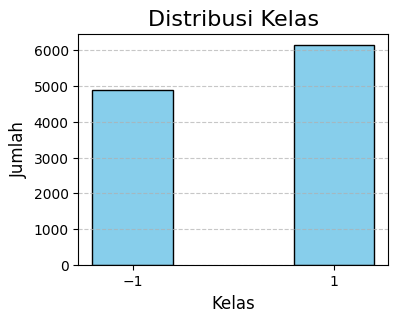

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Asumsi 'df' adalah DataFrame Anda dan 'result' adalah kolom target
y = df['result']

# Cek distribusi kelas
class_counts = Counter(y)
print("Distribusi kelas:", class_counts)

# Hitung rasio ketidakseimbangan
majority_class = max(class_counts, key=class_counts.get)  # Kelas mayoritas
minority_class = min(class_counts, key=class_counts.get)  # Kelas minoritas

majority_count = class_counts[majority_class]
minority_count = class_counts[minority_class]

imbalance_ratio = majority_count / minority_count
print(f"Rasio ketidakseimbangan: {imbalance_ratio:.2f}")

# Menghitung persentase distribusi kelas
total_count = len(y)
majority_percentage = (majority_count / total_count) * 100
minority_percentage = (minority_count / total_count) * 100

print(f"Persentase kelas mayoritas: {majority_percentage:.2f}%")
print(f"Persentase kelas minoritas: {minority_percentage:.2f}%")

# Jika lebih dari 2 kelas, bisa ditambahkan pengecekan untuk distribusi lainnya
if len(class_counts) > 2:
    for label, count in class_counts.items():
        percentage = (count / total_count) * 100
        print(f"Persentase kelas {label}: {percentage:.2f}%")

# Menampilkan histogram distribusi kelas
plt.figure(figsize=(4, 3))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='black')
plt.title('Distribusi Kelas', fontsize=16)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(list(class_counts.keys()), fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Tida diilakukan smoting atau penyeimbangan data karena untuk mengetes algoritma random forest dalam data tidak seimbang dan pada penelitian sebelumnya juga tidak dilaukan smote.

### Test sebelum Feature Selection

In [17]:
X = df.drop(columns='result')  # Fitur
y = df['result']

# Membagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Latih model
model.fit(X_train, y_train)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Evaluasi model
print("\nHasil Evaluasi Model Random Forest:")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred) * 100  # Konversi ke persentase
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

# Jika ingin menampilkan dalam format seperti "96.789%" tambahkan tanda %
print(f"Akurasi: {accuracy:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-Score: {f1:.3f}%")


Hasil Evaluasi Model Random Forest:
Akurasi: 96.698%
Precision: 96.707%
Recall: 96.698%
F1-Score: 96.694%


## Feature Selection

### Chi-Square

**Cara kerja Chi-Square**:
- Chi square tidak dapat menggunakan data negative
- Membandingkan frekuensi yang diamati (observe) dengan frekuensi yang diharapkan (expect).
- Dimana frekuensi yang diamati adalah data sebenarnya

| Gender      | Kelas 1 | Kelas 2 | Kelas 3 | Total |
|-------------|---------|---------|---------|-------|
| Pria (0)    |    5    |   10    |    5    |   20  |
| Wanita (1)  |    5    |    2    |    3    |   10  |
| **Total**   |   10    |   12    |    8    |   30  |


- Dengan frekuensi yang diharapkan dihitung dengan rumus =


 $$ E = \frac{(TotalGender \times TotalKelas)}{TotalSampel}$$

- Untuk Pria di Kelas 1 =
$$ E = \frac{(20 \times 10)}{30} = 6.67 $$

- Frekuensi yang diharapkan =

| Gender      | Kelas 1 | Kelas 2 | Kelas 3 | Total |
|-------------|---------|---------|---------|-------|
| Pria (0)    | 6.67    | 8       | 5.33    | 20    |
| Wanita (1)  | 3.33    | 4       | 2.67    | 10    |
| **Total**   | 10      | 12      | 8       | 30    |


- Jadi Tabel Kontingens, ini menunjukan distribusi frekuensi yang diamati:


| Gender      | Kelas 1     | Kelas 2     | Kelas 3     | Total |
|-------------|-------------|-------------|-------------|-------|
| Pria (0)    | 5 (6.67)    | 10 (8)      | 5 (5.33)    | 20    |
| Wanita (1)  | 5 (3.33)    | 2 (4)       | 3 (2.67)    | 10    |
| **Total**   | 10          | 12          | 8           | 30    |


- **Rumus Chi-Square**

Rumus untuk menghitung nilai Chi-Square $( \chi^2 )$ adalah:

$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$

di mana:

- $( O_i )$ = Jumlah observasi aktual (Observed frequency)
- $( E_i )$ = Jumlah observasi yang diharapkan (Expected frequency)

- Selanjutnya Hitung total Cho Square dengan cara menjumlah dari semua nilai chi square per kategori.
- entukan Signifikansi Statistik Untuk menentukan signifikansi statistik, kita perlu membandingkan nilai Chi-Square dengan nilai kritis dari distribusi Chi-Square pada tingkat signifikansi tertentu (**misalnya, 0.05**) dan derajat kebebasan (df) tertentu.

$$ df = (Baris - 1) \times (Kolom - 1) = (2 - 1) \times (3 - 1) = 2 $$
- Untuk df = 2 dan α = 0.05, nilai kritis sekitar 5.99. Tabel Chi-Square biasanya tersedia di buku statistik atau secara online.
- Dengan fungsi **chi2** dari library scipy.stats akan menghasilkan nilai kritis.



---


Chi-Square hanya dapat mengolah bilangan bulat, bilangan negatif tidak dapat diolah maka, -1 diganti dengan 0 dan 0 diganti menjadi 1 dan 1 diganti menjadi 2

In [19]:
# Buat salinan DataFrame
df_chi = df.copy()

# Ganti nilai di semua kolom fitur (mengabaikan kolom target)
for col in df_chi.columns[:-1]:  # Mengabaikan kolom target
    df_chi[col] = df_chi[col].replace({-1: 0, 0: 1, 1: 2})

# Tampilkan DataFrame setelah penggantian
print("\nDataFrame setelah mengganti nilai:")
print(df_chi)

# Inisialisasi hasil
results = []


DataFrame setelah mengganti nilai:
       having_ip_address  url_length  shortining_service  having_at_symbol  \
0                      0           2                   2                 2   
1                      2           2                   2                 2   
2                      2           1                   2                 2   
3                      2           1                   2                 2   
4                      2           1                   0                 2   
...                  ...         ...                 ...               ...   
11050                  2           0                   2                 0   
11051                  0           2                   2                 0   
11052                  2           0                   2                 2   
11053                  0           0                   2                 2   
11054                  0           0                   2                 2   

       double_slash_redirec

In [20]:
# Lakukan Chi-Square untuk setiap fitur
for feature in df_chi.columns[:-1]:  # Mengabaikan kolom target
    contingency_table = pd.crosstab(df_chi[feature], df_chi['result'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Simpan hasil
    results.append({
        'Feature': feature,
        'Chi2': chi2,
        'P-Value': p_value,
        'Degrees of Freedom': dof,
        'Expected Frequencies': expected.flatten()
    })

# Buat DataFrame hasil
results_df = pd.DataFrame(results)

# Tentukan threshold untuk p-value
alpha = 0.5
results_df['Significant'] = results_df['P-Value'] < alpha

# Tampilkan hasil
print("\nHasil Pengujian Chi-Square:")
print(results_df)

# Fitur yang signifikan
significant_features = results_df[results_df['Significant']]
print("\nFitur yang Signifikan (p-value < 0.05):")
print(significant_features[['Feature', 'P-Value']])


Hasil Pengujian Chi-Square:
                       Feature         Chi2        P-Value  \
0            having_ip_address    97.616128   5.078857e-23   
1                   url_length    57.774681   2.846999e-13   
2           shortining_service    50.661841   1.097324e-12   
3             having_at_symbol    30.694313   3.020491e-08   
4     double_slash_redirecting    16.247156   5.559299e-05   
5                prefix_suffix  1341.399192  1.139474e-293   
6            having_sub_domain  1595.294123   0.000000e+00   
7               sslfinal_state  6686.246056   0.000000e+00   
8   domain_registration_length   562.628588  2.253279e-124   
9                      favicon     0.000023   9.961924e-01   
10                        port    14.449423   1.439740e-04   
11                 https_token    17.342195   3.121778e-05   
12                 request_url   708.665429  3.902709e-156   
13               url_of_anchor  5966.367231   0.000000e+00   
14               links_in_tags   712.5648

In [21]:
# Fitur yang signifikan
significant_features = results_df[results_df['Significant']]['Feature']

# Mengambil Data dari Fitur yang Signifikan
# Buat DataFrame baru yang hanya berisi fitur signifikan dan kolom target
df_significant = df_chi[significant_features.tolist() + ['result']]

# Tampilkan DataFrame baru
print("\nDataFrame dengan fitur yang signifikan:")
print(df_significant)


DataFrame dengan fitur yang signifikan:
       having_ip_address  url_length  shortining_service  having_at_symbol  \
0                      0           2                   2                 2   
1                      2           2                   2                 2   
2                      2           1                   2                 2   
3                      2           1                   2                 2   
4                      2           1                   0                 2   
...                  ...         ...                 ...               ...   
11050                  2           0                   2                 0   
11051                  0           2                   2                 0   
11052                  2           0                   2                 2   
11053                  0           0                   2                 2   
11054                  0           0                   2                 2   

       double_slash_re

In [22]:
# Misalkan df adalah dataframe asli Anda dan df_significant adalah dataframe dengan kolom yang ingin dipilih

# Membuat df_selected dengan kolom yang sama seperti di df_significant dari df
df_selected = df[df_significant.columns]
df_selected.head()


,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,port,...,on_mouseover,rightclick,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [23]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   having_ip_address           11055 non-null  int64
 1   url_length                  11055 non-null  int64
 2   shortining_service          11055 non-null  int64
 3   having_at_symbol            11055 non-null  int64
 4   double_slash_redirecting    11055 non-null  int64
 5   prefix_suffix               11055 non-null  int64
 6   having_sub_domain           11055 non-null  int64
 7   sslfinal_state              11055 non-null  int64
 8   domain_registration_length  11055 non-null  int64
 9   port                        11055 non-null  int64
 10  https_token                 11055 non-null  int64
 11  request_url                 11055 non-null  int64
 12  url_of_anchor               11055 non-null  int64
 13  links_in_tags               11055 non-null  int64
 14  sfh   

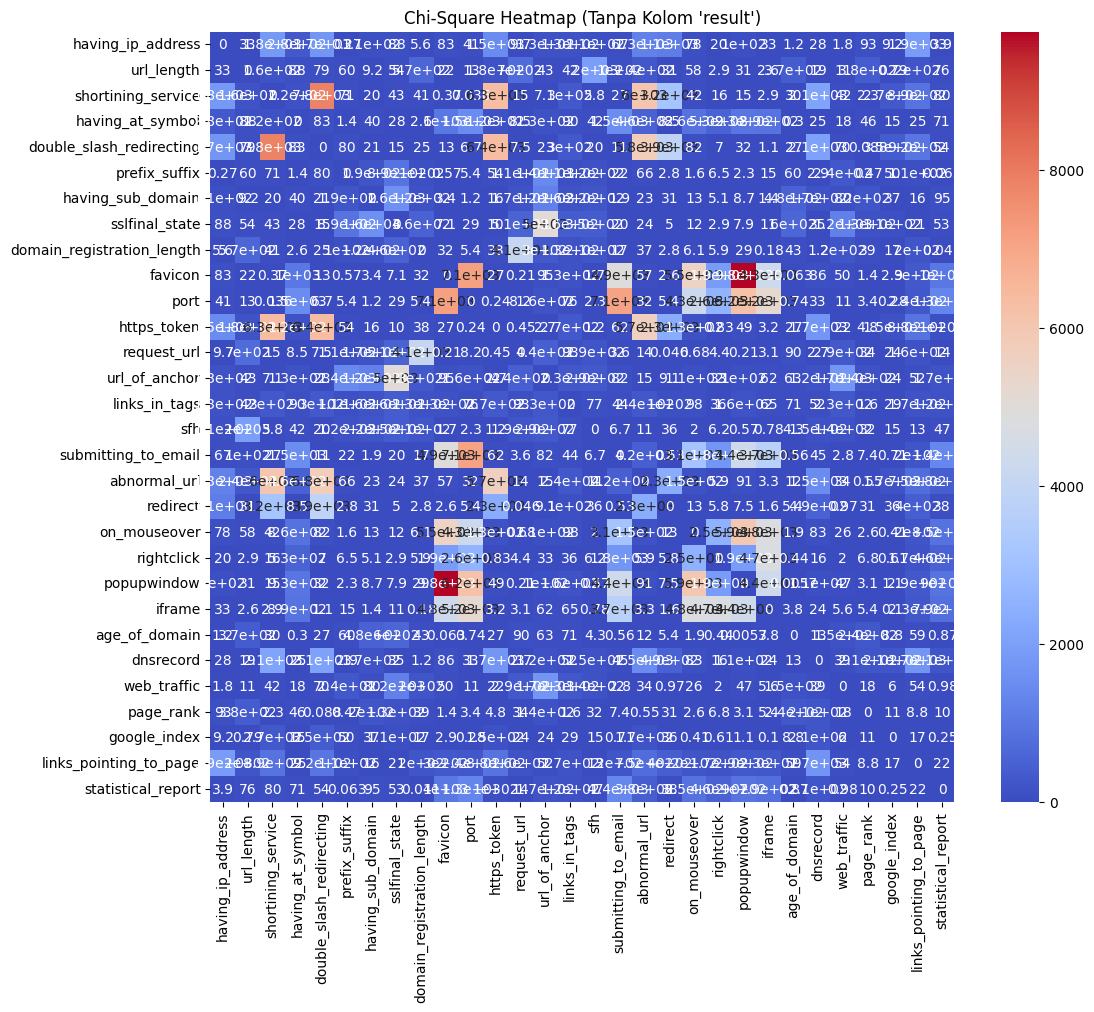

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Fungsi untuk menghitung matriks Chi-Square
def calculate_chi_square_matrix(df, exclude_columns=None):
    if exclude_columns:
        df = df.drop(columns=exclude_columns)  # Hapus kolom yang dikecualikan

    features = df.columns
    n_features = len(features)

    chi_square_matrix = np.zeros((n_features, n_features))

    # Iterasi untuk setiap pasangan fitur
    for i, col1 in enumerate(features):
        for j, col2 in enumerate(features):
            if i != j:  # Tidak menghitung diagonal
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                chi_square_matrix[i, j] = chi2

    return pd.DataFrame(chi_square_matrix, index=features, columns=features)

# Hitung matriks Chi-Square tanpa kolom 'result'
chi_square_matrix = calculate_chi_square_matrix(df, exclude_columns=['result'])

# Plot heatmap menggunakan seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(chi_square_matrix, annot=True, cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("Chi-Square Heatmap (Tanpa Kolom 'result')")
plt.show()


#### Test Random Forest Chi Sqare

In [25]:
# Pisahkan fitur dan target
X_chi = df_selected.drop(columns='result')  # Fitur
y_chi = df_selected['result']  # Target

In [26]:
# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_chi, y_chi, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Latih model
model.fit(X_train, y_train)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Evaluasi model
print("\nHasil Evaluasi Model Random Forest:")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred) * 100  # Konversi ke persentase
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

# Jika ingin menampilkan dalam format seperti "96.789%" tambahkan tanda %
print(f"Akurasi: {accuracy:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-Score: {f1:.3f}%")



Hasil Evaluasi Model Random Forest:
Akurasi: 96.879%
Precision: 96.888%
Recall: 96.879%
F1-Score: 96.875%


In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Pisahkan fitur dan target
X = X_chi  # Asumsikan 'result' adalah kolom target
y = y_chi

# Inisialisasi model Random Forest dengan parameter yang ditentukan
# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Inisialisasi Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
recalls = []

# Loop untuk setiap fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Pisahkan data latih dan data uji untuk fold ini
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi pada data uji
    y_pred = model.predict(X_test)

    # Hitung akurasi dan recall untuk fold ini
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='binary')  # Jika target biner, gunakan 'binary'

    # Simpan hasil
    accuracies.append(accuracy)
    recalls.append(recall)

    # Tampilkan informasi setiap fold
    print(f"Fold {fold}:")
    print(f"  Data latih: {len(train_index)}")
    print(f"  Data uji: {len(test_index)}")
    print(f"  Akurasi: {accuracy:.4f}")
    print(f"  Precision: {recall:.4f}")
    print()

# Tampilkan rata-rata dan deviasi standar metrik
print("Rata-rata hasil cross-validation:")
print(f"  Akurasi: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"  Precision: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")


Fold 1:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9693
  Precision: 0.9854

Fold 2:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9684
  Precision: 0.9805

Fold 3:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9783
  Precision: 0.9838

Fold 4:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9711
  Precision: 0.9692

Fold 5:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9747
  Precision: 0.9740

Fold 6:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9747
  Precision: 0.9886

Fold 7:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9683
  Precision: 0.9821

Fold 8:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9729
  Precision: 0.9837

Fold 9:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9747
  Precision: 0.9854

Fold 10:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9710
  Precision: 0.9838

Rata-rata hasil cross-validation:
  Akurasi: 0.9723 ± 0.0031
  Precision: 0.9816 ± 0.0055


Menggunakan Chi-Square mendapat hasil akurasi 0.9683 atau 96.83% dengan Precision 96.84%, Recall 96.83%, dan F1-Score 96.82%

### RFE

**Cara kerja RFE pada Algoritma Random Forest** :
- Misal memiliki 30 fitur X dan 1 y, maka RFE akan melatih dengan random forest
- Hasil train akan menghasailkan feature importance, RFE akan mengambil fitur berdasarkan fitur importance
- Setelah mendapat hasil 1 fitur X dengan importance terendah akan dihapus kemudian rfe akan melatih kembali dengan 29 fitur lainnya.
- itu akan diulang sampai memenuhi n_features_to_select

In [28]:
# Membagi dataset menjadi data latih dan data uji
X = df.drop(columns='result')  # Fitur
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Inisialisasi RFE
rfe = RFE(estimator=model, n_features_to_select=25)  # Pilih 2 fitur terpenting

# Melatih RFE
rfe.fit(X_train, y_train)

# Mendapatkan fitur terpilih
selected_features = X.columns[rfe.support_]
# Menggunakan fitur terpilih dengan benar
filtered_X = X[selected_features]
print("Fitur terpilih:", selected_features)

X1 = filtered_X

Fitur terpilih: Index(['having_ip_address', 'url_length', 'shortining_service',
       'having_at_symbol', 'prefix_suffix', 'having_sub_domain',
       'sslfinal_state', 'domain_registration_length', 'favicon',
       'https_token', 'request_url', 'url_of_anchor', 'links_in_tags', 'sfh',
       'submitting_to_email', 'abnormal_url', 'redirect', 'popupwindow',
       'age_of_domain', 'dnsrecord', 'web_traffic', 'page_rank',
       'google_index', 'links_pointing_to_page', 'statistical_report'],
      dtype='object')


Fitur terpilih: ['having_ip_address', 'url_length', 'shortining_service', 'having_at_symbol', 'prefix_suffix', 'having_sub_domain', 'sslfinal_state', 'domain_registration_length', 'favicon', 'https_token', 'request_url', 'url_of_anchor', 'links_in_tags', 'sfh', 'submitting_to_email', 'abnormal_url', 'redirect', 'popupwindow', 'age_of_domain', 'dnsrecord', 'web_traffic', 'page_rank', 'google_index', 'links_pointing_to_page', 'statistical_report']

Feature Importance dari RFE:
                       Feature  Importance
6               sslfinal_state    0.335734
11               url_of_anchor    0.241186
20                 web_traffic    0.065969
5            having_sub_domain    0.063678
4                prefix_suffix    0.054053
12               links_in_tags    0.042189
13                         sfh    0.019401
23      links_pointing_to_page    0.019245
10                 request_url    0.019100
18               age_of_domain    0.015784
7   domain_registration_length    0.015150
0   

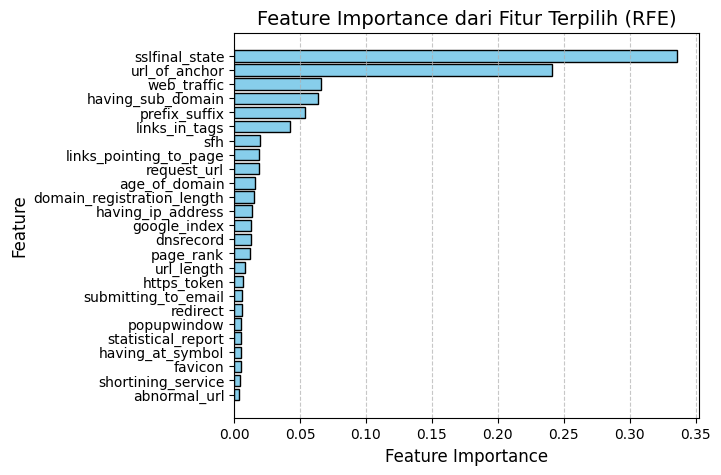

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import pandas as pd

# Membagi dataset menjadi data latih dan data uji
X = df.drop(columns='result')  # Fitur
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Inisialisasi RFE
rfe = RFE(estimator=model, n_features_to_select=25)  # Pilih 25 fitur terpenting

# Melatih RFE
rfe.fit(X_train, y_train)

# Mendapatkan fitur terpilih
selected_features = X.columns[rfe.support_]
print("Fitur terpilih:", list(selected_features))

# Menghitung feature importance dari fitur terpilih
feature_importances = rfe.estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Menampilkan feature importance
print("\nFeature Importance dari RFE:")
print(feature_importance_df)

# Visualisasi feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance dari Fitur Terpilih (RFE)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Menggunakan RFE mendapat hasil akurasi 0.9687 atau 96.87% dengan Precision 96.88%, Recall 96.87%, dan F1-Score 96.87%

#### Test Random Forest RFE

In [30]:
# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Latih model
model.fit(X_train, y_train)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Evaluasi model
print("\nHasil Evaluasi Model Random Forest:")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred) * 100  # Konversi ke persentase
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

# Jika ingin menampilkan dalam format seperti "96.789%" tambahkan tanda %
print(f"Akurasi: {accuracy:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-Score: {f1:.3f}%")


Hasil Evaluasi Model Random Forest:
Akurasi: 96.879%
Precision: 96.884%
Recall: 96.879%
F1-Score: 96.876%


Akurasi: 0.9687924016282226

Precision: 0.9688835631741882

Recall: 0.9687924016282226

F1-Score: 0.9687485842945072

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Pisahkan fitur dan target
X = X1  # Asumsikan 'result' adalah kolom target
y = df['result']

# Inisialisasi model Random Forest dengan parameter yang ditentukan
# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Inisialisasi Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
recalls = []

# Loop untuk setiap fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Pisahkan data latih dan data uji untuk fold ini
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi pada data uji
    y_pred = model.predict(X_test)

    # Hitung akurasi dan recall untuk fold ini
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='binary')  # Jika target biner, gunakan 'binary'

    # Simpan hasil
    accuracies.append(accuracy)
    recalls.append(recall)

    # Tampilkan informasi setiap fold
    print(f"Fold {fold}:")
    print(f"  Data latih: {len(train_index)}")
    print(f"  Data uji: {len(test_index)}")
    print(f"  Akurasi: {accuracy:.4f}")
    print(f"  Precision: {recall:.4f}")
    print()

# Tampilkan rata-rata dan deviasi standar metrik
print("Rata-rata hasil cross-validation:")
print(f"  Akurasi: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"  Precision: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")


Fold 1:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9711
  Precision: 0.9870

Fold 2:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9656
  Precision: 0.9805

Fold 3:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9783
  Precision: 0.9854

Fold 4:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9720
  Precision: 0.9692

Fold 5:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9765
  Precision: 0.9773

Fold 6:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9719
  Precision: 0.9870

Fold 7:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9701
  Precision: 0.9805

Fold 8:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9719
  Precision: 0.9789

Fold 9:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9738
  Precision: 0.9838

Fold 10:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9674
  Precision: 0.9821

Rata-rata hasil cross-validation:
  Akurasi: 0.9719 ± 0.0036
  Precision: 0.9812 ± 0.0051


In [32]:
X = df[['sslfinal_state','url_of_anchor','web_traffic','having_sub_domain']]
y = df['result']

# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest
model = RandomForestClassifier(random_state=42)

# Latih model
model.fit(X_train, y_train)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Evaluasi model
print("\nHasil Evaluasi Model Random Forest:")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred) * 100  # Konversi ke persentase
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

# Jika ingin menampilkan dalam format seperti "96.789%" tambahkan tanda %
print(f"Akurasi: {accuracy:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-Score: {f1:.3f}%")


Hasil Evaluasi Model Random Forest:
Akurasi: 96.879%
Precision: 96.884%
Recall: 96.879%
F1-Score: 96.876%


## Hyperparameter

### Bayesian Optimization TPE

 Berbeda dari metode optimasi tradisional, seperti grid search atau random search, yang mencoba berbagai kombinasi parameter secara langsung. Bayesian Optimization menggunakan pendekatan probabilistik untuk memperkirakan distribusi dari fungsi yang ingin dioptimasi, lalu memilih titik evaluasi yang diharapkan memberikan informasi paling bermanfaat.

Proses Bayesian Optimization melibatkan dua langkah utama:

- Modeling: TPE dengan framework Optuna
- Optimization: Menggunakan fungsi akuisisi untuk memilih titik terbaik berikutnya untuk dievaluasi secara nyata pada fungsi objektif.

**Konsep Dasar Bayesian Optimization dengan TPE**

Bayesian Optimization adalah metode yang menggunakan probabilitas untuk memprediksi performa dari berbagai kombinasi parameter dan memilih kombinasi terbaik untuk evaluasi lebih lanjut. TPE adalah salah satu implementasi populer dari Bayesian Optimization.

**Langkah-langkah TPE**

1. **Membangun Model Awal**:
   - TPE memulai dengan model awal yang memprediksi performa dari parameter-parameter yang sedang dievaluasi.

2. **Menghitung Probabilitas**:
   - TPE menggunakan distribusi Parzen (Parzen window) untuk menghitung probabilitas bahwa parameter tertentu akan memberikan performa yang baik.
   - Probabilitas ini dihitung berdasarkan data yang sudah ada dari evaluasi sebelumnya.

3. **Memilih Parameter untuk Evaluasi**:
   - TPE memilih parameter yang memiliki probabilitas terbaik untuk performa yang baik.
   - Parameter yang dipilih kemudian dievaluasi untuk mendapatkan performanya.

4. **Memperbarui Model**:
   - Setelah parameter dievaluasi, model TPE diperbarui dengan data baru ini.
   - Model kini lebih baik dalam memprediksi performa parameter baru berdasarkan data yang sudah ada.

5. **Ulangi Proses**:
   - Proses ini diulang hingga mencapai batas waktu atau iterasi yang diinginkan.

**Keuntungan TPE**

- **Efisiensi**: TPE lebih efisien dibandingkan dengan metode grid search atau random search karena fokus pada area yang paling potensial.
- **Adaptif**: TPE dapat menyesuaikan diri berdasarkan data yang dikumpulkan selama proses optimasi.
- **Penghematan Waktu**: Dengan fokus pada parameter yang paling relevan, TPE dapat mengurangi jumlah evaluasi yang diperlukan.

**Parameter :** n_estimator, max_depth, min_samples_split, min_samples_leaf,max_features, boostrap, random_state

##### BO

In [ ]:
import time
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = df.drop(columns='result')
y = df['result']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # New hyperparameter
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    print(f"Hyperparameters yang diuji: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
          f"bootstrap={bootstrap}, max_features={max_features}")

    # Create and train model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,  # Include the new hyperparameter
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize the objective function
print("Memulai Bayesian Optimization...")
start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
end_time = time.time()
print("Bayesian Optimization selesai.")

# Calculate and print total computation time
total_time = end_time - start_time
print(f"Total waktu komputasi: {total_time:.2f} detik")

# Print best parameters
print(f'Best hyperparameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')


[I 2024-11-21 09:53:28,832] A new study created in memory with name: no-name-110fc649-b087-4696-8644-3112adbed735


Memulai Bayesian Optimization...
Hyperparameters yang diuji: n_estimators=105, max_depth=15, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:53:29,534] Trial 0 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 105, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=148, max_depth=25, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 09:53:30,845] Trial 1 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 148, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=456, max_depth=17, min_samples_split=9, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 09:53:34,078] Trial 2 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 456, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=403, max_depth=25, min_samples_split=2, min_samples_leaf=5, bootstrap=False, max_features=None


[I 2024-11-21 09:53:41,115] Trial 3 finished with value: 0.9448213478064225 and parameters: {'n_estimators': 403, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=203, max_depth=3, min_samples_split=2, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:53:41,843] Trial 4 finished with value: 0.9285391225689733 and parameters: {'n_estimators': 203, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=326, max_depth=30, min_samples_split=5, min_samples_leaf=10, bootstrap=False, max_features=log2


[I 2024-11-21 09:53:43,954] Trial 5 finished with value: 0.9493441881501583 and parameters: {'n_estimators': 326, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=251, max_depth=19, min_samples_split=5, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:53:46,067] Trial 6 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 251, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=159, max_depth=30, min_samples_split=9, min_samples_leaf=8, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:53:47,002] Trial 7 finished with value: 0.9479873360470376 and parameters: {'n_estimators': 159, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=379, max_depth=41, min_samples_split=7, min_samples_leaf=9, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:53:49,240] Trial 8 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 379, 'max_depth': 41, 'min_samples_split': 7, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=210, max_depth=3, min_samples_split=7, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-11-21 09:53:50,691] Trial 9 finished with value: 0.9222071460877431 and parameters: {'n_estimators': 210, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=293, max_depth=47, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:53:52,823] Trial 10 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 293, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9665309814563546.


Hyperparameters yang diuji: n_estimators=113, max_depth=49, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:53:53,669] Trial 11 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 113, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9669832654907282.


Hyperparameters yang diuji: n_estimators=292, max_depth=50, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:53:55,747] Trial 12 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 292, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9669832654907282.


Hyperparameters yang diuji: n_estimators=485, max_depth=50, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:00,390] Trial 13 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 485, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=468, max_depth=40, min_samples_split=4, min_samples_leaf=4, bootstrap=False, max_features=None


[I 2024-11-21 09:54:08,656] Trial 14 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 468, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=497, max_depth=42, min_samples_split=4, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:12,957] Trial 15 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 497, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=376, max_depth=36, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:15,422] Trial 16 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 376, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=324, max_depth=46, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:17,688] Trial 17 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 324, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=415, max_depth=37, min_samples_split=3, min_samples_leaf=4, bootstrap=False, max_features=log2


[I 2024-11-21 09:54:20,122] Trial 18 finished with value: 0.9601990049751243 and parameters: {'n_estimators': 415, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=243, max_depth=50, min_samples_split=10, min_samples_leaf=3, bootstrap=False, max_features=None


[I 2024-11-21 09:54:25,067] Trial 19 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 243, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=160, max_depth=33, min_samples_split=5, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:26,585] Trial 20 finished with value: 0.9556761646313885 and parameters: {'n_estimators': 160, 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=284, max_depth=50, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:28,611] Trial 21 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 284, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=100, max_depth=45, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:29,361] Trial 22 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 100, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=210, max_depth=50, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:30,800] Trial 23 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 210, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=349, max_depth=43, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:33,230] Trial 24 finished with value: 0.966078697421981 and parameters: {'n_estimators': 349, 'max_depth': 43, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=265, max_depth=38, min_samples_split=3, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:34,915] Trial 25 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 265, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=435, max_depth=45, min_samples_split=7, min_samples_leaf=3, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:54:37,860] Trial 26 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 435, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=359, max_depth=10, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:40,651] Trial 27 finished with value: 0.9520578923563998 and parameters: {'n_estimators': 359, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=318, max_depth=48, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 09:54:46,463] Trial 28 finished with value: 0.9565807327001357 and parameters: {'n_estimators': 318, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=484, max_depth=43, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 09:54:49,438] Trial 29 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 484, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=128, max_depth=22, min_samples_split=2, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:50,501] Trial 30 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 128, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=296, max_depth=47, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:53,630] Trial 31 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 296, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=226, max_depth=47, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:55,159] Trial 32 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 226, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=281, max_depth=48, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:57,180] Trial 33 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 281, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=182, max_depth=39, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 09:54:58,390] Trial 34 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 182, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=124, max_depth=34, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:54:59,300] Trial 35 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 124, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=399, max_depth=43, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:55:01,698] Trial 36 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 399, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=348, max_depth=44, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 09:55:04,189] Trial 37 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 348, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=439, max_depth=50, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:55:07,846] Trial 38 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 439, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=189, max_depth=27, min_samples_split=5, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:09,070] Trial 39 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 189, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=241, max_depth=14, min_samples_split=6, min_samples_leaf=3, bootstrap=False, max_features=None


[I 2024-11-21 09:55:13,356] Trial 40 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 241, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=319, max_depth=46, min_samples_split=8, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:16,380] Trial 41 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 319, 'max_depth': 46, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=265, max_depth=47, min_samples_split=8, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:19,377] Trial 42 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 265, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=300, max_depth=48, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:21,928] Trial 43 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 300, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=329, max_depth=45, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:24,278] Trial 44 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 329, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=380, max_depth=41, min_samples_split=4, min_samples_leaf=10, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:55:26,324] Trial 45 finished with value: 0.9484396200814111 and parameters: {'n_estimators': 380, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=340, max_depth=50, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:28,662] Trial 46 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 340, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=425, max_depth=41, min_samples_split=5, min_samples_leaf=8, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:31,385] Trial 47 finished with value: 0.9538670284938942 and parameters: {'n_estimators': 425, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=399, max_depth=44, min_samples_split=2, min_samples_leaf=4, bootstrap=False, max_features=None


[I 2024-11-21 09:55:39,314] Trial 48 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 399, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=453, max_depth=35, min_samples_split=3, min_samples_leaf=7, bootstrap=True, max_features=log2


[I 2024-11-21 09:55:41,592] Trial 49 finished with value: 0.9484396200814111 and parameters: {'n_estimators': 453, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=142, max_depth=45, min_samples_split=4, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:42,505] Trial 50 finished with value: 0.9556761646313885 and parameters: {'n_estimators': 142, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=332, max_depth=48, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:45,316] Trial 51 finished with value: 0.966078697421981 and parameters: {'n_estimators': 332, 'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=307, max_depth=46, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:48,220] Trial 52 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 307, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=366, max_depth=40, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:50,801] Trial 53 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 366, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=365, max_depth=31, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:53,259] Trial 54 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 365, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=311, max_depth=41, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:55,466] Trial 55 finished with value: 0.966078697421981 and parameters: {'n_estimators': 311, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=274, max_depth=38, min_samples_split=4, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:55:57,271] Trial 56 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 274, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=469, max_depth=49, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:01,866] Trial 57 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 469, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=473, max_depth=45, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:05,209] Trial 58 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 473, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=498, max_depth=49, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=None


[I 2024-11-21 09:56:15,357] Trial 59 finished with value: 0.9516056083220262 and parameters: {'n_estimators': 498, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=455, max_depth=39, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:18,567] Trial 60 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 455, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=469, max_depth=46, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:21,865] Trial 61 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 469, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=482, max_depth=46, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:25,794] Trial 62 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 482, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=474, max_depth=43, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:29,856] Trial 63 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 474, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=483, max_depth=42, min_samples_split=5, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:33,040] Trial 64 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 483, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=473, max_depth=43, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:36,383] Trial 65 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 473, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=467, max_depth=43, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:40,437] Trial 66 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 467, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=446, max_depth=37, min_samples_split=5, min_samples_leaf=9, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:43,391] Trial 67 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 446, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=483, max_depth=40, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 09:56:46,344] Trial 68 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 483, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=467, max_depth=47, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:49,692] Trial 69 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 467, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=421, max_depth=49, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:53,161] Trial 70 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 421, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=489, max_depth=45, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:56:57,187] Trial 71 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 489, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=493, max_depth=43, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:00,736] Trial 72 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 493, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=477, max_depth=46, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:04,150] Trial 73 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 477, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=459, max_depth=44, min_samples_split=5, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:08,388] Trial 74 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 459, 'max_depth': 44, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=437, max_depth=40, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:11,519] Trial 75 finished with value: 0.968340117593849 and parameters: {'n_estimators': 437, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=433, max_depth=39, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:14,644] Trial 76 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 433, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=500, max_depth=5, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:16,687] Trial 77 finished with value: 0.9384893713251922 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=412, max_depth=42, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 09:57:25,322] Trial 78 finished with value: 0.9543193125282677 and parameters: {'n_estimators': 412, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=444, max_depth=32, min_samples_split=4, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:28,247] Trial 79 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 444, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=464, max_depth=29, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:57:31,016] Trial 80 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 464, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=491, max_depth=49, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:35,736] Trial 81 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 491, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=476, max_depth=44, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:39,116] Trial 82 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 476, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=449, max_depth=40, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:42,302] Trial 83 finished with value: 0.968340117593849 and parameters: {'n_estimators': 449, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=448, max_depth=35, min_samples_split=10, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:45,494] Trial 84 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 448, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=431, max_depth=40, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:49,255] Trial 85 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 431, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=409, max_depth=23, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 09:57:52,012] Trial 86 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 409, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=459, max_depth=37, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:55,219] Trial 87 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 459, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=392, max_depth=42, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:57:58,188] Trial 88 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 392, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=442, max_depth=47, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:02,137] Trial 89 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 442, 'max_depth': 47, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=476, max_depth=49, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:05,494] Trial 90 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 476, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=489, max_depth=46, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:08,974] Trial 91 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 489, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=483, max_depth=44, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:13,233] Trial 92 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 483, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=453, max_depth=42, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:16,840] Trial 93 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 453, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=462, max_depth=48, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:19,981] Trial 94 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 462, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=472, max_depth=45, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:23,341] Trial 95 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 472, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=489, max_depth=41, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:27,842] Trial 96 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 489, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=424, max_depth=38, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 09:58:35,567] Trial 97 finished with value: 0.9543193125282677 and parameters: {'n_estimators': 424, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=437, max_depth=16, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:58:38,655] Trial 98 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 437, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=452, max_depth=46, min_samples_split=7, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:58:42,251] Trial 99 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 452, 'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.968340117593849.


Bayesian Optimization selesai.
Total waktu komputasi: 313.42 detik
Best hyperparameters: {'n_estimators': 437, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}
Best accuracy: 0.968340117593849


Total waktu komputasi: 313.42 detik
Best hyperparameters: {'n_estimators': 437, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}
Best accuracy: 0.968340117593849



---


##### BO Chi-S

In [ ]:
import time
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = X_chi
y = y_chi

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # New hyperparameter
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    print(f"Hyperparameters yang diuji: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
          f"bootstrap={bootstrap}, max_features={max_features}")

    # Create and train model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,  # Include the new hyperparameter
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize the objective function
print("Memulai Bayesian Optimization...")
start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
end_time = time.time()
print("Bayesian Optimization selesai.")

# Calculate and print total computation time
total_time = end_time - start_time
print(f"Total waktu komputasi: {total_time:.2f} detik")

# Print best parameters
print(f'Best hyperparameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')


[I 2024-11-21 09:59:08,476] A new study created in memory with name: no-name-7a1deed2-7c75-4f21-b9da-eb49666c3a69


Memulai Bayesian Optimization...
Hyperparameters yang diuji: n_estimators=345, max_depth=29, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:59:10,868] Trial 0 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 345, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=257, max_depth=21, min_samples_split=7, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-11-21 09:59:14,075] Trial 1 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 257, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=337, max_depth=34, min_samples_split=4, min_samples_leaf=10, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:59:16,484] Trial 2 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 337, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=395, max_depth=8, min_samples_split=7, min_samples_leaf=9, bootstrap=False, max_features=None


[I 2024-11-21 09:59:22,600] Trial 3 finished with value: 0.9380370872908186 and parameters: {'n_estimators': 395, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=250, max_depth=49, min_samples_split=3, min_samples_leaf=4, bootstrap=False, max_features=None


[I 2024-11-21 09:59:26,748] Trial 4 finished with value: 0.9484396200814111 and parameters: {'n_estimators': 250, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=434, max_depth=6, min_samples_split=8, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 09:59:33,037] Trial 5 finished with value: 0.9366802351876978 and parameters: {'n_estimators': 434, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=156, max_depth=39, min_samples_split=9, min_samples_leaf=6, bootstrap=True, max_features=log2


[I 2024-11-21 09:59:33,821] Trial 6 finished with value: 0.9538670284938942 and parameters: {'n_estimators': 156, 'max_depth': 39, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=477, max_depth=43, min_samples_split=7, min_samples_leaf=8, bootstrap=False, max_features=None


[I 2024-11-21 09:59:41,386] Trial 7 finished with value: 0.9439167797376753 and parameters: {'n_estimators': 477, 'max_depth': 43, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=114, max_depth=47, min_samples_split=8, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 09:59:42,326] Trial 8 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 114, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=478, max_depth=49, min_samples_split=5, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:59:46,222] Trial 9 finished with value: 0.95838986883763 and parameters: {'n_estimators': 478, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=332, max_depth=21, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 09:59:48,201] Trial 10 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 332, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=107, max_depth=29, min_samples_split=10, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 09:59:48,876] Trial 11 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 107, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=198, max_depth=13, min_samples_split=5, min_samples_leaf=3, bootstrap=False, max_features=log2


[I 2024-11-21 09:59:50,018] Trial 12 finished with value: 0.9565807327001357 and parameters: {'n_estimators': 198, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=372, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 09:59:52,504] Trial 13 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 372, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=391, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:59:55,329] Trial 14 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 391, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=403, max_depth=36, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 09:59:59,355] Trial 15 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 403, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=388, max_depth=22, min_samples_split=3, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-11-21 10:00:01,484] Trial 16 finished with value: 0.9547715965626413 and parameters: {'n_estimators': 388, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=281, max_depth=32, min_samples_split=5, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:03,286] Trial 17 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 281, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=440, max_depth=15, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:00:05,771] Trial 18 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 440, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=372, max_depth=26, min_samples_split=4, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:08,144] Trial 19 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 372, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=304, max_depth=40, min_samples_split=4, min_samples_leaf=6, bootstrap=False, max_features=log2


[I 2024-11-21 10:00:10,544] Trial 20 finished with value: 0.9561284486657621 and parameters: {'n_estimators': 304, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=425, max_depth=36, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:14,092] Trial 21 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 425, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=408, max_depth=37, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:17,001] Trial 22 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 408, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=355, max_depth=43, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:19,276] Trial 23 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 355, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=453, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:22,697] Trial 24 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 453, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=305, max_depth=31, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:25,925] Trial 25 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 305, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=497, max_depth=24, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:00:29,698] Trial 26 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 497, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=389, max_depth=18, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:32,264] Trial 27 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 389, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=374, max_depth=34, min_samples_split=2, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:34,529] Trial 28 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 374, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=351, max_depth=30, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 10:00:36,677] Trial 29 finished with value: 0.966078697421981 and parameters: {'n_estimators': 351, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=417, max_depth=43, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:40,594] Trial 30 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 417, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=417, max_depth=36, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:43,507] Trial 31 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 417, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=460, max_depth=27, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:46,692] Trial 32 finished with value: 0.968340117593849 and parameters: {'n_estimators': 460, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=330, max_depth=35, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:00:48,932] Trial 33 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 330, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=417, max_depth=39, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:00:51,878] Trial 34 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 417, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=356, max_depth=32, min_samples_split=4, min_samples_leaf=10, bootstrap=False, max_features=None


[I 2024-11-21 10:00:58,148] Trial 35 finished with value: 0.9407507914970602 and parameters: {'n_estimators': 356, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=436, max_depth=33, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:01,357] Trial 36 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 436, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=397, max_depth=28, min_samples_split=6, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-11-21 10:01:07,488] Trial 37 finished with value: 0.9606512890094979 and parameters: {'n_estimators': 397, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=255, max_depth=41, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:09,320] Trial 38 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 255, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=376, max_depth=37, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=None


[I 2024-11-21 10:01:15,811] Trial 39 finished with value: 0.9538670284938942 and parameters: {'n_estimators': 376, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=314, max_depth=45, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=log2


[I 2024-11-21 10:01:17,982] Trial 40 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 314, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=407, max_depth=37, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:21,935] Trial 41 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 407, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=430, max_depth=37, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:25,050] Trial 42 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 430, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=459, max_depth=3, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:26,619] Trial 43 finished with value: 0.9271822704658526 and parameters: {'n_estimators': 459, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=495, max_depth=34, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:30,186] Trial 44 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 495, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=368, max_depth=24, min_samples_split=2, min_samples_leaf=8, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:33,292] Trial 45 finished with value: 0.9552238805970149 and parameters: {'n_estimators': 368, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=397, max_depth=29, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:01:36,020] Trial 46 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 397, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=229, max_depth=39, min_samples_split=8, min_samples_leaf=9, bootstrap=False, max_features=log2


[I 2024-11-21 10:01:37,291] Trial 47 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 229, 'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=284, max_depth=47, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 10:01:42,199] Trial 48 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 284, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=334, max_depth=42, min_samples_split=10, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:44,464] Trial 49 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 334, 'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=478, max_depth=31, min_samples_split=2, min_samples_leaf=4, bootstrap=False, max_features=log2


[I 2024-11-21 10:01:48,311] Trial 50 finished with value: 0.9606512890094979 and parameters: {'n_estimators': 478, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=396, max_depth=18, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:51,001] Trial 51 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 396, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=383, max_depth=18, min_samples_split=9, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:53,533] Trial 52 finished with value: 0.966078697421981 and parameters: {'n_estimators': 383, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=448, max_depth=24, min_samples_split=7, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:56,580] Trial 53 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 448, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=427, max_depth=11, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:01:59,994] Trial 54 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 427, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=404, max_depth=35, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:03,209] Trial 55 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 404, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 55 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=412, max_depth=35, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:02:05,676] Trial 56 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 412, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 55 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=466, max_depth=38, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:02:08,797] Trial 57 finished with value: 0.968340117593849 and parameters: {'n_estimators': 466, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 55 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=365, max_depth=33, min_samples_split=2, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:11,384] Trial 58 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 365, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 55 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=345, max_depth=30, min_samples_split=3, min_samples_leaf=7, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:14,580] Trial 59 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 345, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 55 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=443, max_depth=35, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 10:02:17,383] Trial 60 finished with value: 0.966078697421981 and parameters: {'n_estimators': 443, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 55 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=404, max_depth=18, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:20,198] Trial 61 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 404, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=400, max_depth=32, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:23,023] Trial 62 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 400, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=420, max_depth=9, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:25,912] Trial 63 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 420, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=127, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:27,429] Trial 64 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 127, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=379, max_depth=28, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:30,136] Trial 65 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 379, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=409, max_depth=41, min_samples_split=2, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:32,685] Trial 66 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 409, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=431, max_depth=16, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-11-21 10:02:38,349] Trial 67 finished with value: 0.966078697421981 and parameters: {'n_estimators': 431, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=360, max_depth=26, min_samples_split=5, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:41,648] Trial 68 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 360, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=389, max_depth=36, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:02:44,323] Trial 69 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 389, 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=443, max_depth=33, min_samples_split=7, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:47,343] Trial 70 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 443, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=386, max_depth=14, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:49,849] Trial 71 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 386, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=320, max_depth=19, min_samples_split=7, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:52,660] Trial 72 finished with value: 0.968340117593849 and parameters: {'n_estimators': 320, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=407, max_depth=39, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:56,061] Trial 73 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 407, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=426, max_depth=21, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:02:59,088] Trial 74 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 426, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=374, max_depth=31, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:01,769] Trial 75 finished with value: 0.968340117593849 and parameters: {'n_estimators': 374, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=401, max_depth=29, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:04,579] Trial 76 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 401, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=390, max_depth=37, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:08,416] Trial 77 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 390, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=350, max_depth=35, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:03:10,643] Trial 78 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 350, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=419, max_depth=19, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 10:03:17,833] Trial 79 finished with value: 0.9570330167345092 and parameters: {'n_estimators': 419, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=467, max_depth=12, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:21,925] Trial 80 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 467, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=408, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:24,926] Trial 81 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 408, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=404, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:27,881] Trial 82 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 404, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=437, max_depth=40, min_samples_split=2, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:30,615] Trial 83 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 437, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=384, max_depth=34, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:34,562] Trial 84 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 384, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=369, max_depth=32, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:37,272] Trial 85 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 369, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=368, max_depth=27, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:39,748] Trial 86 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 368, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=343, max_depth=31, min_samples_split=8, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:42,199] Trial 87 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 343, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=324, max_depth=33, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:03:44,410] Trial 88 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 324, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=363, max_depth=16, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:47,987] Trial 89 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 363, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=451, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:03:50,937] Trial 90 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 451, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=392, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:53,776] Trial 91 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 392, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=413, max_depth=32, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:03:56,773] Trial 92 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 413, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=426, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:04:00,872] Trial 93 finished with value: 0.968340117593849 and parameters: {'n_estimators': 426, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=378, max_depth=30, min_samples_split=5, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:04:03,638] Trial 94 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 378, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=399, max_depth=34, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:04:06,547] Trial 95 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 399, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=421, max_depth=44, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 10:04:15,012] Trial 96 finished with value: 0.95838986883763 and parameters: {'n_estimators': 421, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=206, max_depth=40, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 10:04:16,403] Trial 97 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 206, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=357, max_depth=37, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:04:18,928] Trial 98 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 357, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=294, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:04:21,107] Trial 99 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 294, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.9701492537313433.


Bayesian Optimization selesai.
Total waktu komputasi: 312.63 detik
Best hyperparameters: {'n_estimators': 404, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}
Best accuracy: 0.9701492537313433


Total waktu komputasi: 312.63 detik
Best hyperparameters: {'n_estimators': 404, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}
Best accuracy: 0.9701492537313433



---
##### BO RFE


In [ ]:
filtered_X.head()

,having_ip_address,url_length,shortining_service,having_at_symbol,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,https_token,...,abnormal_url,redirect,popupwindow,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
0,-1,1,1,1,-1,-1,-1,-1,1,-1,...,-1,0,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,-1,0,1,-1,1,-1,...,1,0,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,-1,-1,-1,-1,1,-1,...,-1,0,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,-1,-1,-1,1,1,-1,...,1,0,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,-1,1,1,-1,1,1,...,1,0,-1,-1,-1,0,-1,1,1,1


In [ ]:
import time
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = filtered_X
y = df['result']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # New hyperparameter
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    print(f"Hyperparameters yang diuji: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
          f"bootstrap={bootstrap}, max_features={max_features}")

    # Create and train model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,  # Include the new hyperparameter
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize the objective function
print("Memulai Bayesian Optimization...")
start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
end_time = time.time()
print("Bayesian Optimization selesai.")

# Calculate and print total computation time
total_time = end_time - start_time
print(f"Total waktu komputasi: {total_time:.2f} detik")

# Print best parameters
print(f'Best hyperparameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')


[I 2024-11-21 10:17:23,966] A new study created in memory with name: no-name-1a5e7fba-3c0c-4966-aaba-3d3a4911468c


Memulai Bayesian Optimization...
Hyperparameters yang diuji: n_estimators=138, max_depth=12, min_samples_split=10, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:17:24,751] Trial 0 finished with value: 0.9511533242876526 and parameters: {'n_estimators': 138, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9511533242876526.


Hyperparameters yang diuji: n_estimators=342, max_depth=10, min_samples_split=5, min_samples_leaf=6, bootstrap=True, max_features=None


[I 2024-11-21 10:17:28,836] Trial 1 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 342, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': None}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=406, max_depth=5, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:17:31,394] Trial 2 finished with value: 0.9353233830845771 and parameters: {'n_estimators': 406, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=120, max_depth=19, min_samples_split=6, min_samples_leaf=7, bootstrap=True, max_features=log2


[I 2024-11-21 10:17:32,022] Trial 3 finished with value: 0.9507010402532791 and parameters: {'n_estimators': 120, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=226, max_depth=30, min_samples_split=5, min_samples_leaf=8, bootstrap=False, max_features=None


[I 2024-11-21 10:17:35,508] Trial 4 finished with value: 0.9448213478064225 and parameters: {'n_estimators': 226, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': None}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=493, max_depth=34, min_samples_split=6, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:17:38,269] Trial 5 finished with value: 0.9570330167345092 and parameters: {'n_estimators': 493, 'max_depth': 34, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=387, max_depth=50, min_samples_split=5, min_samples_leaf=7, bootstrap=True, max_features=None


[I 2024-11-21 10:17:43,495] Trial 6 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 387, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': None}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=462, max_depth=3, min_samples_split=10, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-11-21 10:17:45,458] Trial 7 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 462, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=357, max_depth=30, min_samples_split=4, min_samples_leaf=7, bootstrap=False, max_features=None


[I 2024-11-21 10:17:50,972] Trial 8 finished with value: 0.9479873360470376 and parameters: {'n_estimators': 357, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': None}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=478, max_depth=32, min_samples_split=7, min_samples_leaf=10, bootstrap=False, max_features=sqrt


[I 2024-11-21 10:17:53,731] Trial 9 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 478, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=280, max_depth=19, min_samples_split=8, min_samples_leaf=4, bootstrap=False, max_features=None


[I 2024-11-21 10:17:59,361] Trial 10 finished with value: 0.9461781999095432 and parameters: {'n_estimators': 280, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': None}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=331, max_depth=50, min_samples_split=3, min_samples_leaf=9, bootstrap=True, max_features=None


[I 2024-11-21 10:18:03,170] Trial 11 finished with value: 0.952962460425147 and parameters: {'n_estimators': 331, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': None}. Best is trial 1 with value: 0.9579375848032564.


Hyperparameters yang diuji: n_estimators=398, max_depth=45, min_samples_split=4, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-11-21 10:18:07,899] Trial 12 finished with value: 0.95838986883763 and parameters: {'n_estimators': 398, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 12 with value: 0.95838986883763.


Hyperparameters yang diuji: n_estimators=271, max_depth=44, min_samples_split=4, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-11-21 10:18:12,316] Trial 13 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 271, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 13 with value: 0.9592944369063772.


Hyperparameters yang diuji: n_estimators=256, max_depth=42, min_samples_split=2, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-11-21 10:18:15,408] Trial 14 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 256, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 14 with value: 0.9597467209407508.


Hyperparameters yang diuji: n_estimators=228, max_depth=40, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-11-21 10:18:18,302] Trial 15 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 228, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 15 with value: 0.9651741293532339.


Hyperparameters yang diuji: n_estimators=195, max_depth=39, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:19,522] Trial 16 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 195, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 16 with value: 0.9669832654907282.


Hyperparameters yang diuji: n_estimators=183, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:20,683] Trial 17 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 183, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=166, max_depth=37, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:21,998] Trial 18 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 166, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=178, max_depth=24, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:23,600] Trial 19 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 178, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=188, max_depth=26, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:25,155] Trial 20 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 188, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=169, max_depth=37, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:26,317] Trial 21 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 169, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=149, max_depth=37, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:27,362] Trial 22 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 149, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=211, max_depth=38, min_samples_split=2, min_samples_leaf=3, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:28,685] Trial 23 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 211, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=113, max_depth=46, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:29,398] Trial 24 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 113, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=201, max_depth=35, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:30,727] Trial 25 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 201, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=241, max_depth=41, min_samples_split=8, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-11-21 10:18:32,198] Trial 26 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 241, 'max_depth': 41, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=158, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:33,197] Trial 27 finished with value: 0.968340117593849 and parameters: {'n_estimators': 158, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=108, max_depth=24, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:33,817] Trial 28 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 108, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=144, max_depth=19, min_samples_split=10, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:34,639] Trial 29 finished with value: 0.9611035730438715 and parameters: {'n_estimators': 144, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=142, max_depth=29, min_samples_split=4, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:18:35,791] Trial 30 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 142, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=162, max_depth=33, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:37,347] Trial 31 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 162, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=198, max_depth=40, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:38,810] Trial 32 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 198, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=301, max_depth=48, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:40,544] Trial 33 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 301, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=203, max_depth=42, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:41,808] Trial 34 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 203, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 27 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=129, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:42,636] Trial 35 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 129, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=127, max_depth=15, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:43,368] Trial 36 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 127, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=103, max_depth=27, min_samples_split=5, min_samples_leaf=3, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:18:43,997] Trial 37 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 103, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=130, max_depth=16, min_samples_split=2, min_samples_leaf=6, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:44,733] Trial 38 finished with value: 0.9502487562189055 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=236, max_depth=9, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:45,907] Trial 39 finished with value: 0.9488919041157847 and parameters: {'n_estimators': 236, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=435, max_depth=21, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:18:48,748] Trial 40 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 435, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=196, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:50,579] Trial 41 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 196, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=218, max_depth=39, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:52,215] Trial 42 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 218, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=155, max_depth=28, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:53,132] Trial 43 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 155, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=178, max_depth=35, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:54,248] Trial 44 finished with value: 0.968340117593849 and parameters: {'n_estimators': 178, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=179, max_depth=35, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:55,264] Trial 45 finished with value: 0.9606512890094979 and parameters: {'n_estimators': 179, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=121, max_depth=33, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:56,070] Trial 46 finished with value: 0.968340117593849 and parameters: {'n_estimators': 121, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=129, max_depth=32, min_samples_split=9, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:18:56,837] Trial 47 finished with value: 0.9601990049751243 and parameters: {'n_estimators': 129, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=105, max_depth=24, min_samples_split=5, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:57,483] Trial 48 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 105, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=138, max_depth=34, min_samples_split=6, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:58,361] Trial 49 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 138, 'max_depth': 34, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=299, max_depth=30, min_samples_split=4, min_samples_leaf=10, bootstrap=True, max_features=log2


[I 2024-11-21 10:18:59,879] Trial 50 finished with value: 0.9470827679782904 and parameters: {'n_estimators': 299, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=175, max_depth=35, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:00,969] Trial 51 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 175, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=177, max_depth=35, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:02,458] Trial 52 finished with value: 0.968340117593849 and parameters: {'n_estimators': 177, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=156, max_depth=26, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:03,855] Trial 53 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 156, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=116, max_depth=35, min_samples_split=2, min_samples_leaf=8, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:04,665] Trial 54 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 116, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=164, max_depth=32, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-11-21 10:19:06,733] Trial 55 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 164, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=176, max_depth=29, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:07,845] Trial 56 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 176, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=123, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:08,648] Trial 57 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 123, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=247, max_depth=36, min_samples_split=3, min_samples_leaf=6, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:09,977] Trial 58 finished with value: 0.9507010402532791 and parameters: {'n_estimators': 247, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=215, max_depth=33, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:11,199] Trial 59 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 215, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=356, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:19:13,447] Trial 60 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 356, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=178, max_depth=43, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:14,754] Trial 61 finished with value: 0.968340117593849 and parameters: {'n_estimators': 178, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=148, max_depth=45, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:16,169] Trial 62 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 148, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=152, max_depth=46, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:17,543] Trial 63 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 152, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=144, max_depth=48, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-11-21 10:19:19,431] Trial 64 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 144, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=121, max_depth=42, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:20,162] Trial 65 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 121, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=188, max_depth=44, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:21,378] Trial 66 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 188, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=135, max_depth=43, min_samples_split=2, min_samples_leaf=9, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:22,117] Trial 67 finished with value: 0.9497964721845319 and parameters: {'n_estimators': 135, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=152, max_depth=48, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:19:23,181] Trial 68 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 152, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=168, max_depth=26, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:24,136] Trial 69 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 168, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=267, max_depth=39, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:25,836] Trial 70 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 267, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=171, max_depth=37, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:26,912] Trial 71 finished with value: 0.968340117593849 and parameters: {'n_estimators': 171, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=187, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:28,427] Trial 72 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 187, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=160, max_depth=40, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:29,964] Trial 73 finished with value: 0.968340117593849 and parameters: {'n_estimators': 160, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=223, max_depth=45, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:31,425] Trial 74 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 223, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=116, max_depth=33, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:32,176] Trial 75 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 116, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=100, max_depth=37, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:32,807] Trial 76 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=138, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-11-21 10:19:35,181] Trial 77 finished with value: 0.9556761646313885 and parameters: {'n_estimators': 138, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=205, max_depth=31, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:36,353] Trial 78 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 205, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=174, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:37,459] Trial 79 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 174, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=189, max_depth=2, min_samples_split=2, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:19:38,111] Trial 80 finished with value: 0.9240162822252375 and parameters: {'n_estimators': 189, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=162, max_depth=41, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:39,154] Trial 81 finished with value: 0.968340117593849 and parameters: {'n_estimators': 162, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=157, max_depth=40, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:40,131] Trial 82 finished with value: 0.968340117593849 and parameters: {'n_estimators': 157, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=131, max_depth=41, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:41,232] Trial 83 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 131, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=147, max_depth=43, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:42,562] Trial 84 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 147, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=132, max_depth=46, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:43,788] Trial 85 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 132, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=128, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:44,632] Trial 86 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 128, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=129, max_depth=49, min_samples_split=6, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:45,403] Trial 87 finished with value: 0.9606512890094979 and parameters: {'n_estimators': 129, 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=110, max_depth=46, min_samples_split=7, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:46,060] Trial 88 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 110, 'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=136, max_depth=47, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-11-21 10:19:46,996] Trial 89 finished with value: 0.966078697421981 and parameters: {'n_estimators': 136, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=120, max_depth=49, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-11-21 10:19:48,534] Trial 90 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 120, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=146, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:49,459] Trial 91 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 146, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=144, max_depth=49, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:50,385] Trial 92 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 144, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=143, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:51,301] Trial 93 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 143, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=132, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:52,180] Trial 94 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 132, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=147, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:53,118] Trial 95 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 147, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=144, max_depth=50, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:54,249] Trial 96 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 144, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=131, max_depth=50, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:55,443] Trial 97 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 131, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=110, max_depth=47, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-11-21 10:19:56,574] Trial 98 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 110, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 35 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=148, max_depth=49, min_samples_split=3, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-11-21 10:19:57,597] Trial 99 finished with value: 0.9511533242876526 and parameters: {'n_estimators': 148, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.9692446856625961.


Bayesian Optimization selesai.
Total waktu komputasi: 153.63 detik
Best hyperparameters: {'n_estimators': 129, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}
Best accuracy: 0.9692446856625961


Total waktu komputasi: 153.63 detik
Best hyperparameters: {'n_estimators': 129, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}
Best accuracy: 0.9692446856625961

#### BO best feature

In [ ]:
import time
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = df[['sslfinal_state','url_of_anchor','web_traffic','having_sub_domain']]
y = df['result']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # New hyperparameter
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    print(f"Hyperparameters yang diuji: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
          f"bootstrap={bootstrap}, max_features={max_features}")

    # Create and train model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,  # Include the new hyperparameter
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize the objective function
print("Memulai Bayesian Optimization...")
start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
end_time = time.time()
print("Bayesian Optimization selesai.")

# Calculate and print total computation time
total_time = end_time - start_time
print(f"Total waktu komputasi: {total_time:.2f} detik")

# Print best parameters
print(f'Best hyperparameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')


[I 2024-12-11 10:05:31,760] A new study created in memory with name: no-name-e82874f8-e886-4d26-8176-35c453c7f945


Memulai Bayesian Optimization...
Hyperparameters yang diuji: n_estimators=324, max_depth=30, min_samples_split=4, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:32,920] Trial 0 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 324, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=116, max_depth=6, min_samples_split=4, min_samples_leaf=6, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:05:33,317] Trial 1 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 116, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=394, max_depth=5, min_samples_split=4, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-12-11 10:05:34,449] Trial 2 finished with value: 0.9226594301221167 and parameters: {'n_estimators': 394, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=250, max_depth=18, min_samples_split=8, min_samples_leaf=9, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:35,295] Trial 3 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 250, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=299, max_depth=30, min_samples_split=9, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:05:36,318] Trial 4 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 299, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=257, max_depth=25, min_samples_split=9, min_samples_leaf=5, bootstrap=False, max_features=None


[I 2024-12-11 10:05:37,302] Trial 5 finished with value: 0.9285391225689733 and parameters: {'n_estimators': 257, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=282, max_depth=14, min_samples_split=7, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-12-11 10:05:38,180] Trial 6 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 282, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=355, max_depth=33, min_samples_split=5, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-12-11 10:05:39,269] Trial 7 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 355, 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=242, max_depth=42, min_samples_split=7, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-12-11 10:05:40,013] Trial 8 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 242, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=161, max_depth=8, min_samples_split=6, min_samples_leaf=9, bootstrap=True, max_features=None


[I 2024-12-11 10:05:40,665] Trial 9 finished with value: 0.9280868385345997 and parameters: {'n_estimators': 161, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9294436906377205.


Hyperparameters yang diuji: n_estimators=484, max_depth=45, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:43,331] Trial 10 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 484, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=438, max_depth=48, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:45,480] Trial 11 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 438, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=499, max_depth=49, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:47,201] Trial 12 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 499, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=493, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:48,918] Trial 13 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 493, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=410, max_depth=40, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:50,370] Trial 14 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 410, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=430, max_depth=41, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:05:52,065] Trial 15 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 430, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=453, max_depth=46, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:53,665] Trial 16 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 453, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=368, max_depth=36, min_samples_split=5, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:05:55,068] Trial 17 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 368, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=456, max_depth=45, min_samples_split=3, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-12-11 10:05:57,876] Trial 18 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 456, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=475, max_depth=23, min_samples_split=10, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:05:59,764] Trial 19 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 475, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=426, max_depth=37, min_samples_split=5, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:01,245] Trial 20 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 426, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=496, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:03,102] Trial 21 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 496, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=464, max_depth=46, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:04,800] Trial 22 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 464, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=380, max_depth=50, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:06,195] Trial 23 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 380, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=434, max_depth=44, min_samples_split=2, min_samples_leaf=4, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:07,746] Trial 24 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 434, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=341, max_depth=38, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:09,419] Trial 25 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 341, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=484, max_depth=47, min_samples_split=4, min_samples_leaf=10, bootstrap=False, max_features=log2


[I 2024-12-11 10:06:11,791] Trial 26 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 484, 'max_depth': 47, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=400, max_depth=43, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:13,159] Trial 27 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 400, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=195, max_depth=32, min_samples_split=3, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-12-11 10:06:13,932] Trial 28 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 195, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=327, max_depth=36, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:15,125] Trial 29 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 327, 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=448, max_depth=48, min_samples_split=6, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:16,673] Trial 30 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 448, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=424, max_depth=40, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:06:18,287] Trial 31 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 424, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=472, max_depth=42, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:06:20,066] Trial 32 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 472, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=438, max_depth=50, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:06:21,910] Trial 33 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 438, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=393, max_depth=40, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-12-11 10:06:24,247] Trial 34 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 393, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=499, max_depth=44, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:26,385] Trial 35 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 499, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=410, max_depth=47, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=None


[I 2024-12-11 10:06:27,867] Trial 36 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 410, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=476, max_depth=2, min_samples_split=4, min_samples_leaf=6, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:29,246] Trial 37 finished with value: 0.9127091813658977 and parameters: {'n_estimators': 476, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=372, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-11 10:06:30,465] Trial 38 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 372, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=107, max_depth=29, min_samples_split=5, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:30,886] Trial 39 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 107, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=306, max_depth=16, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:06:32,105] Trial 40 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 306, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=474, max_depth=22, min_samples_split=10, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:33,764] Trial 41 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 474, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=452, max_depth=26, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:35,363] Trial 42 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 452, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=489, max_depth=10, min_samples_split=8, min_samples_leaf=8, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:38,168] Trial 43 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 489, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=423, max_depth=28, min_samples_split=10, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:40,089] Trial 44 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 423, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=468, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-11 10:06:41,566] Trial 45 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 468, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=440, max_depth=34, min_samples_split=8, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:43,068] Trial 46 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 440, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=136, max_depth=23, min_samples_split=6, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:43,585] Trial 47 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 136, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=413, max_depth=13, min_samples_split=3, min_samples_leaf=6, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:45,066] Trial 48 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 413, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=272, max_depth=42, min_samples_split=9, min_samples_leaf=4, bootstrap=False, max_features=None


[I 2024-12-11 10:06:46,099] Trial 49 finished with value: 0.9285391225689733 and parameters: {'n_estimators': 272, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=211, max_depth=48, min_samples_split=7, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:06:46,876] Trial 50 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 211, 'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=487, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:48,643] Trial 51 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 487, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=495, max_depth=45, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:51,089] Trial 52 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 495, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=462, max_depth=47, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:53,640] Trial 53 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 462, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=454, max_depth=45, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:55,299] Trial 54 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 454, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=499, max_depth=49, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:57,076] Trial 55 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 499, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=477, max_depth=40, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-11 10:06:59,458] Trial 56 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 477, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=439, max_depth=50, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:01,610] Trial 57 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 439, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=388, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:02,982] Trial 58 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 388, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=484, max_depth=43, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:05,611] Trial 59 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 484, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=462, max_depth=46, min_samples_split=2, min_samples_leaf=5, bootstrap=False, max_features=None


[I 2024-12-11 10:07:08,044] Trial 60 finished with value: 0.9285391225689733 and parameters: {'n_estimators': 462, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=471, max_depth=48, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:09,722] Trial 61 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 471, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=448, max_depth=46, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:11,302] Trial 62 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 448, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=426, max_depth=38, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:12,778] Trial 63 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 426, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=464, max_depth=43, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:14,430] Trial 64 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 464, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=357, max_depth=49, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:15,711] Trial 65 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 357, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=485, max_depth=47, min_samples_split=2, min_samples_leaf=10, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:17,463] Trial 66 finished with value: 0.9285391225689733 and parameters: {'n_estimators': 485, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=444, max_depth=41, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-11 10:07:20,222] Trial 67 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 444, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=500, max_depth=31, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:07:22,243] Trial 68 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 500, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=458, max_depth=44, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:23,865] Trial 69 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 458, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=402, max_depth=45, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:07:25,441] Trial 70 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 402, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=338, max_depth=37, min_samples_split=5, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:26,664] Trial 71 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 338, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=309, max_depth=48, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:27,803] Trial 72 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 309, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=418, max_depth=39, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:29,261] Trial 73 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 418, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=431, max_depth=34, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:30,809] Trial 74 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 431, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=479, max_depth=20, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:33,536] Trial 75 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 479, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=487, max_depth=41, min_samples_split=5, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:07:35,533] Trial 76 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 487, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=246, max_depth=50, min_samples_split=7, min_samples_leaf=8, bootstrap=False, max_features=log2


[I 2024-12-11 10:07:36,352] Trial 77 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 246, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=342, max_depth=43, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-11 10:07:37,685] Trial 78 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 342, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=472, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:39,330] Trial 79 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 472, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=434, max_depth=46, min_samples_split=10, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:07:40,823] Trial 80 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 434, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=451, max_depth=39, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:07:42,558] Trial 81 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 451, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=286, max_depth=35, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:07:43,688] Trial 82 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 286, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=406, max_depth=41, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:07:45,874] Trial 83 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 406, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=390, max_depth=48, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-11 10:07:48,239] Trial 84 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 390, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=377, max_depth=44, min_samples_split=9, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-11 10:07:49,760] Trial 85 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 377, 'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=493, max_depth=49, min_samples_split=6, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:51,528] Trial 86 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 493, 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=420, max_depth=45, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-11 10:07:52,896] Trial 87 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 420, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=468, max_depth=42, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:07:54,575] Trial 88 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 468, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=458, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:07:56,323] Trial 89 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 458, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=480, max_depth=39, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-11 10:07:58,028] Trial 90 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 480, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=232, max_depth=47, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:07:59,515] Trial 91 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 232, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=447, max_depth=42, min_samples_split=8, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:08:02,179] Trial 92 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 447, 'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=472, max_depth=46, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:08:04,099] Trial 93 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 472, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=492, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-11 10:08:06,048] Trial 94 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 492, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=430, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:08:07,631] Trial 95 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 430, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=464, max_depth=44, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-11 10:08:09,439] Trial 96 finished with value: 0.9289914066033469 and parameters: {'n_estimators': 464, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=440, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-11 10:08:10,948] Trial 97 finished with value: 0.9303482587064676 and parameters: {'n_estimators': 440, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=484, max_depth=49, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-11 10:08:13,029] Trial 98 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 484, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.9303482587064676.


Hyperparameters yang diuji: n_estimators=414, max_depth=40, min_samples_split=3, min_samples_leaf=5, bootstrap=False, max_features=log2


[I 2024-12-11 10:08:15,119] Trial 99 finished with value: 0.9294436906377205 and parameters: {'n_estimators': 414, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 10 with value: 0.9303482587064676.


Bayesian Optimization selesai.
Total waktu komputasi: 163.37 detik
Best hyperparameters: {'n_estimators': 484, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}
Best accuracy: 0.9303482587064676




---
## Evaluasi


### Chi-S

n_estimators': 404, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt

In [38]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

print("\nEvaluasi Model Random Forest dengan X_chi dan y_chi:")

X_train, X_test, y_train, y_test = train_test_split(X_chi, y_chi, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=404,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=False,
    max_features="sqrt",
    random_state=42
)

model.fit(X_train, y_train)

model_filename = "random_forest_model.joblib"
joblib.dump(model, model_filename)
print(f"\nModel telah disimpan ke file: {model_filename}")

y_pred = model.predict(X_test)

print("\nHasil Evaluasi Model Random Forest:")

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"Akurasi: {accuracy:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-Score: {f1:.3f}%")

loaded_model = joblib.load(model_filename)
print("\nModel telah berhasil dimuat kembali dari file.")



Evaluasi Model Random Forest dengan X_chi dan y_chi:

Model telah disimpan ke file: random_forest_model.joblib

Hasil Evaluasi Model Random Forest:
Akurasi: 97.015%
Precision: 97.043%
Recall: 97.015%
F1-Score: 97.008%

Model telah berhasil dimuat kembali dari file.


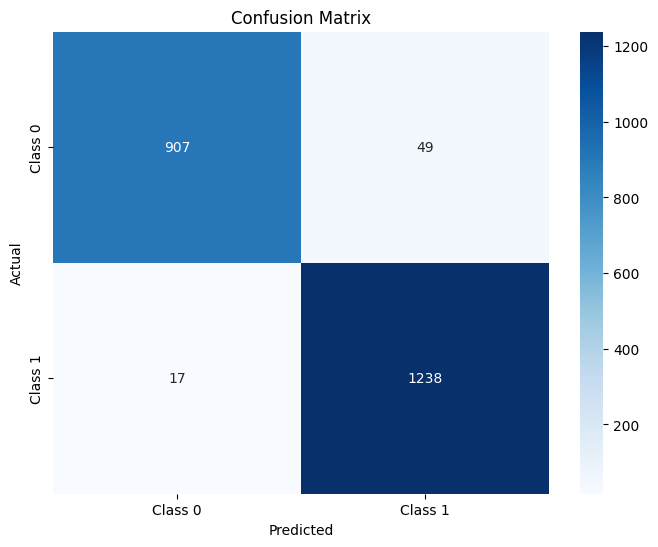

In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("\nEvaluasi Model Random Forest dengan X_chi dan y_chi:")

X = df.drop(columns='result')
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=404,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=False,
    max_features="sqrt",
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\nHasil Evaluasi Model Random Forest:")

accuracy = accuracy_score(y_test, y_pred) * 100  # Konversi ke persentase
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"Akurasi: {accuracy:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-Score: {f1:.3f}%")


Evaluasi Model Random Forest dengan X_chi dan y_chi:

Hasil Evaluasi Model Random Forest:
Akurasi: 96.879%
Precision: 96.905%
Recall: 96.879%
F1-Score: 96.873%


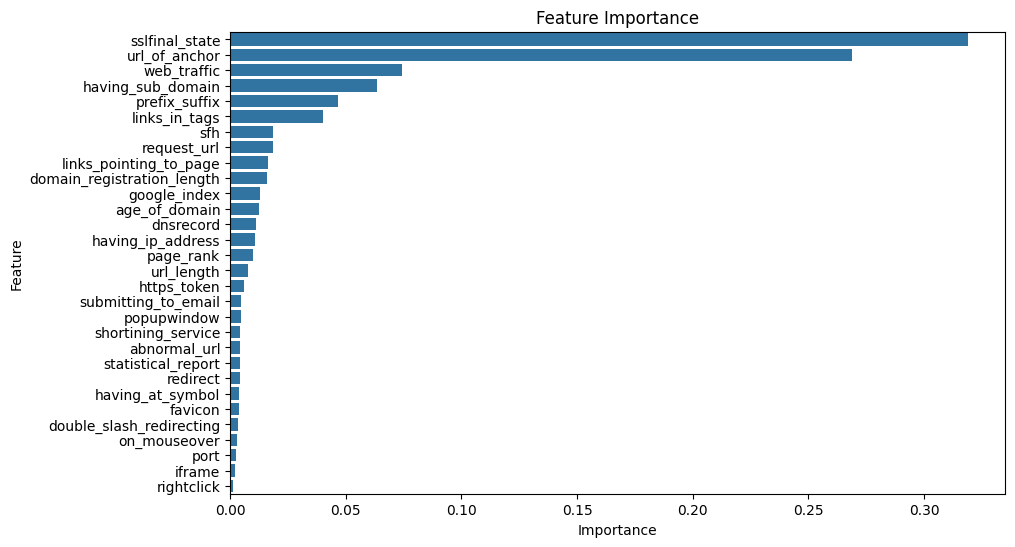

In [ ]:
# Feature Importance (if applicable)
if hasattr(model, 'feature_importances_'):
  feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
  feature_importances = feature_importances.sort_values('Importance', ascending=False)
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importances)
  plt.title('Feature Importance')
  plt.show()

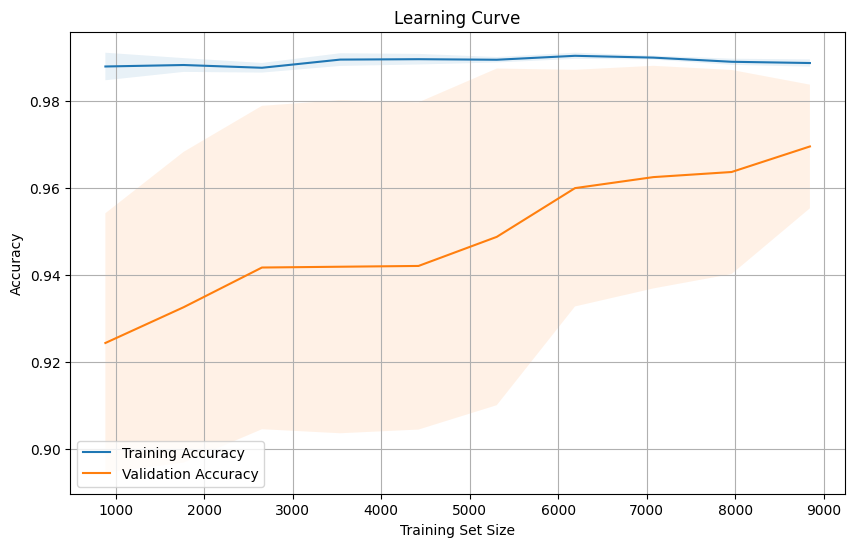

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_chi, y_chi, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

kurva akurasi pelatihan dan validasi mendekati dan tetap tinggi, yang menunjukkan bahwa model telah mempelajari pola umum yang baik dan dapat melakukan generalisasi dengan baik.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = X_chi
y = y_chi

model = RandomForestClassifier(
    n_estimators=404,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=False,
    max_features="sqrt",
    random_state=42
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
recalls = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Hitung akurasi dan recall untuk fold ini
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='binary')

    # Simpan hasil
    accuracies.append(accuracy)
    recalls.append(recall)

    # Tampilkan informasi setiap fold
    print(f"Fold {fold}:")
    print(f"  Data latih: {len(train_index)}")
    print(f"  Data uji: {len(test_index)}")
    print(f"  Akurasi: {accuracy:.4f}")
    print(f"  Precision: {recall:.4f}")
    print()

# Tampilkan rata-rata dan deviasi standar metrik
print("Rata-rata hasil cross-validation:")
print(f"  Akurasi: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"  Precision: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")


Fold 1:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9711
  Precision: 0.9886

Fold 2:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9693
  Precision: 0.9854

Fold 3:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9774
  Precision: 0.9854

Fold 4:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9765
  Precision: 0.9789

Fold 5:
  Data latih: 9949
  Data uji: 1106
  Akurasi: 0.9756
  Precision: 0.9789

Fold 6:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9719
  Precision: 0.9886

Fold 7:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9692
  Precision: 0.9837

Fold 8:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9729
  Precision: 0.9837

Fold 9:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9738
  Precision: 0.9838

Fold 10:
  Data latih: 9950
  Data uji: 1105
  Akurasi: 0.9710
  Precision: 0.9854

Rata-rata hasil cross-validation:
  Akurasi: 0.9729 ± 0.0027
  Precision: 0.9842 ± 0.0032


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

# Pisahkan fitur dan target
X = X_chi  # Asumsikan 'result' adalah kolom target
y = y_chi

# Inisialisasi model Random Forest dengan parameter yang ditentukan
model = RandomForestClassifier(
    n_estimators=404,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=False,
    max_features="sqrt",
    random_state=42
)

# Inisialisasi Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Simpan akurasi dan recall untuk training dan validation
train_accuracies = []
validation_accuracies = []
train_recalls = []
validation_recalls = []

# Loop untuk setiap fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Pisahkan data latih dan data uji untuk fold ini
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi pada data latih dan uji
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Hitung akurasi untuk training dan validation
    train_accuracy = accuracy_score(y_train, y_train_pred)
    validation_accuracy = accuracy_score(y_test, y_test_pred)

    # Hitung recall untuk training dan validation
    train_recall = recall_score(y_train, y_train_pred, average='binary')  # Jika target biner, gunakan 'binary'
    validation_recall = recall_score(y_test, y_test_pred, average='binary')

    # Simpan hasil
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    train_recalls.append(train_recall)
    validation_recalls.append(validation_recall)

    # Tampilkan informasi setiap fold
    print(f"Fold {fold}:")
    print(f"  Data latih: {len(train_index)}")
    print(f"  Data uji: {len(test_index)}")
    print(f"  Akurasi Training: {train_accuracy:.4f}")
    print(f"  Akurasi Validation: {validation_accuracy:.4f}")
    print(f"  Recall Training: {train_recall:.4f}")
    print(f"  Recall Validation: {validation_recall:.4f}")
    print()

# Tampilkan rata-rata dan deviasi standar metrik
print("Rata-rata hasil cross-validation:")
print(f"  Akurasi Training: {np.mean(train_accuracies):.4f} ± {np.std(train_accuracies):.4f}")
print(f"  Akurasi Validation: {np.mean(validation_accuracies):.4f} ± {np.std(validation_accuracies):.4f}")
print(f"  Recall Training: {np.mean(train_recalls):.4f} ± {np.std(train_recalls):.4f}")
print(f"  Recall Validation: {np.mean(validation_recalls):.4f} ± {np.std(validation_recalls):.4f}")


Fold 1:
  Data latih: 9949
  Data uji: 1106
  Akurasi Training: 0.9888
  Akurasi Validation: 0.9711
  Recall Training: 0.9940
  Recall Validation: 0.9886

Fold 2:
  Data latih: 9949
  Data uji: 1106
  Akurasi Training: 0.9887
  Akurasi Validation: 0.9693
  Recall Training: 0.9926
  Recall Validation: 0.9854

Fold 3:
  Data latih: 9949
  Data uji: 1106
  Akurasi Training: 0.9878
  Akurasi Validation: 0.9774
  Recall Training: 0.9933
  Recall Validation: 0.9854

Fold 4:
  Data latih: 9949
  Data uji: 1106
  Akurasi Training: 0.9888
  Akurasi Validation: 0.9765
  Recall Training: 0.9940
  Recall Validation: 0.9789

Fold 5:
  Data latih: 9949
  Data uji: 1106
  Akurasi Training: 0.9886
  Akurasi Validation: 0.9756
  Recall Training: 0.9948
  Recall Validation: 0.9789

Fold 6:
  Data latih: 9950
  Data uji: 1105
  Akurasi Training: 0.9889
  Akurasi Validation: 0.9719
  Recall Training: 0.9951
  Recall Validation: 0.9886

Fold 7:
  Data latih: 9950
  Data uji: 1105
  Akurasi Training: 0.9888

### RFE

In [ ]:
# prompt: buatkan untuk X = filtered_X dan y = df[result] dengan parameter yang digunakan {'n_estimators': 1000, 'max_depth': 17, 'min_samples_split': 2, 'bootstrap': False, 'max_features': 'log2'}

X = filtered_X
y = df['result']

# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest dengan parameter yang ditentukan
model = RandomForestClassifier(
    random_state=42,
    n_estimators=1000,
    max_depth=17,
    min_samples_split=2,
    bootstrap=False,
    max_features='log2'
)

# Latih model
model.fit(X_train, y_train)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Evaluasi model
print("\nHasil Evaluasi Model Random Forest:")
print(classification_report(y_test, y_pred))
print("Akurasi:", accuracy_score(y_test, y_pred))
# Menghitung dan mencetak precision, recall, dan F1-score secara terpisah
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' untuk memperhitungkan ketidakseimbangan kelas
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Hasil Evaluasi Model Random Forest:
              precision    recall  f1-score   support

          -1       0.98      0.95      0.96       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

Akurasi: 0.9696969696969697
Precision: 0.9698817681643561
Recall: 0.9696969696969697
F1-Score: 0.9696411952076396


In [ ]:
# Mendapatkan kolom yang unik di df tetapi tidak ada di df_significant maupun filtered_X
unique_in_df = set(df.columns) - set(df_significant.columns) - set(filtered_X.columns)

# Mendapatkan kolom yang sama antara df_significant dan filtered_X
common_columns = set(df_significant.columns) & set(filtered_X.columns)

# Mendapatkan kolom yang ada di filtered_X tetapi tidak ada di df_significant
unique_in_filtered_X = set(filtered_X.columns) - set(df_significant.columns)

# Mendapatkan kolom yang ada di df_significant tetapi tidak ada di filtered_X
unique_in_df_significant = set(df_significant.columns) - set(filtered_X.columns)

# Menampilkan hasil
print("Kolom yang hanya ada di df, tetapi tidak ada di df_significant maupun filtered_X:")
print(unique_in_df)

print("\nKolom yang sama antara df_significant dan filtered_X:")
print(common_columns)

print("\nKolom yang ada di filtered_X tetapi tidak ada di df_significant:")
print(unique_in_filtered_X)

print("\nKolom yang ada di df_significant tetapi tidak ada di filtered_X:")
print(unique_in_df_significant)


Kolom yang hanya ada di df, tetapi tidak ada di df_significant maupun filtered_X:
{'iframe'}

Kolom yang sama antara df_significant dan filtered_X:
{'url_length', 'links_pointing_to_page', 'redirect', 'statistical_report', 'sslfinal_state', 'web_traffic', 'google_index', 'having_at_symbol', 'request_url', 'submitting_to_email', 'https_token', 'dnsrecord', 'url_of_anchor', 'having_sub_domain', 'age_of_domain', 'shortining_service', 'domain_registration_length', 'having_ip_address', 'sfh', 'links_in_tags', 'prefix_suffix', 'abnormal_url', 'page_rank'}

Kolom yang ada di filtered_X tetapi tidak ada di df_significant:
{'popupwindow', 'favicon'}

Kolom yang ada di df_significant tetapi tidak ada di filtered_X:
{'rightclick', 'result', 'double_slash_redirecting', 'port', 'on_mouseover'}


In [ ]:
df_significant.columns

Index(['having_ip_address', 'url_length', 'shortining_service',
       'having_at_symbol', 'double_slash_redirecting', 'prefix_suffix',
       'having_sub_domain', 'sslfinal_state', 'domain_registration_length',
       'port', 'https_token', 'request_url', 'url_of_anchor', 'links_in_tags',
       'sfh', 'submitting_to_email', 'abnormal_url', 'redirect',
       'on_mouseover', 'rightclick', 'age_of_domain', 'dnsrecord',
       'web_traffic', 'page_rank', 'google_index', 'links_pointing_to_page',
       'statistical_report', 'result'],
      dtype='object')

### BO + Chi-S

In [ ]:
import time
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = X_chi
y = y_chi

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # New hyperparameter
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    print(f"Hyperparameters yang diuji: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
          f"bootstrap={bootstrap}, max_features={max_features}")

    # Create and train model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,  # Include the new hyperparameter
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize the objective function
print("Memulai Bayesian Optimization...")
start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)
end_time = time.time()
print("Bayesian Optimization selesai.")

# Calculate and print total computation time
total_time = end_time - start_time
print(f"Total waktu komputasi: {total_time:.2f} detik")

# Print best parameters
print(f'Best hyperparameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')


[I 2024-12-12 09:47:05,396] A new study created in memory with name: no-name-af8209a9-55ce-4c81-9ca7-62182cf72322


Memulai Bayesian Optimization...
Hyperparameters yang diuji: n_estimators=121, max_depth=30, min_samples_split=8, min_samples_leaf=4, bootstrap=True, max_features=log2


[I 2024-12-12 09:47:06,321] Trial 0 finished with value: 0.9561284486657621 and parameters: {'n_estimators': 121, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9561284486657621.


Hyperparameters yang diuji: n_estimators=433, max_depth=27, min_samples_split=3, min_samples_leaf=7, bootstrap=True, max_features=log2


[I 2024-12-12 09:47:09,551] Trial 1 finished with value: 0.9511533242876526 and parameters: {'n_estimators': 433, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9561284486657621.


Hyperparameters yang diuji: n_estimators=154, max_depth=49, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:47:10,473] Trial 2 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 154, 'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=156, max_depth=48, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:47:11,425] Trial 3 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 156, 'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=124, max_depth=6, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:47:12,012] Trial 4 finished with value: 0.9393939393939394 and parameters: {'n_estimators': 124, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=172, max_depth=15, min_samples_split=2, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:47:13,099] Trial 5 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 172, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=380, max_depth=25, min_samples_split=4, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:47:15,404] Trial 6 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 380, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=163, max_depth=26, min_samples_split=6, min_samples_leaf=8, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:47:16,389] Trial 7 finished with value: 0.9565807327001357 and parameters: {'n_estimators': 163, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=360, max_depth=45, min_samples_split=2, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:47:18,571] Trial 8 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 360, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9642695612844867.


Hyperparameters yang diuji: n_estimators=100, max_depth=31, min_samples_split=8, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:47:20,291] Trial 9 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=257, max_depth=36, min_samples_split=7, min_samples_leaf=9, bootstrap=True, max_features=None


[I 2024-12-12 09:47:24,110] Trial 10 finished with value: 0.952962460425147 and parameters: {'n_estimators': 257, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=231, max_depth=39, min_samples_split=10, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-12-12 09:47:26,976] Trial 11 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 231, 'max_depth': 39, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=251, max_depth=39, min_samples_split=10, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-12-12 09:47:30,089] Trial 12 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 251, 'max_depth': 39, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=497, max_depth=36, min_samples_split=10, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-12-12 09:47:37,253] Trial 13 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 497, 'max_depth': 36, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=279, max_depth=21, min_samples_split=6, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-12-12 09:47:40,747] Trial 14 finished with value: 0.9611035730438715 and parameters: {'n_estimators': 279, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=223, max_depth=39, min_samples_split=8, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:47:43,588] Trial 15 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 223, 'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=206, max_depth=16, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:47:46,459] Trial 16 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 206, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=328, max_depth=43, min_samples_split=8, min_samples_leaf=10, bootstrap=True, max_features=None


[I 2024-12-12 09:47:51,218] Trial 17 finished with value: 0.9516056083220262 and parameters: {'n_estimators': 328, 'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=106, max_depth=32, min_samples_split=5, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:47:52,594] Trial 18 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 106, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=205, max_depth=19, min_samples_split=8, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-12-12 09:47:55,116] Trial 19 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 205, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=313, max_depth=9, min_samples_split=7, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:47:58,707] Trial 20 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 313, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 9 with value: 0.9674355495251018.


Hyperparameters yang diuji: n_estimators=206, max_depth=15, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:48:02,314] Trial 21 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 206, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=199, max_depth=33, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:48:04,963] Trial 22 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 199, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=286, max_depth=13, min_samples_split=7, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:48:08,480] Trial 23 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 286, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=233, max_depth=3, min_samples_split=8, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:48:10,046] Trial 24 finished with value: 0.9222071460877431 and parameters: {'n_estimators': 233, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=189, max_depth=22, min_samples_split=5, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-12-12 09:48:12,471] Trial 25 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 189, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=100, max_depth=10, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=None


[I 2024-12-12 09:48:14,683] Trial 26 finished with value: 0.945273631840796 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=232, max_depth=29, min_samples_split=9, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-12-12 09:48:18,123] Trial 27 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 232, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=138, max_depth=41, min_samples_split=5, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:18,974] Trial 28 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 138, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=133, max_depth=45, min_samples_split=5, min_samples_leaf=4, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:19,719] Trial 29 finished with value: 0.9561284486657621 and parameters: {'n_estimators': 133, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 21 with value: 0.9678878335594754.


Hyperparameters yang diuji: n_estimators=134, max_depth=31, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:20,572] Trial 30 finished with value: 0.968340117593849 and parameters: {'n_estimators': 134, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 30 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=135, max_depth=32, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:21,400] Trial 31 finished with value: 0.968340117593849 and parameters: {'n_estimators': 135, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 30 with value: 0.968340117593849.


Hyperparameters yang diuji: n_estimators=120, max_depth=31, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:22,146] Trial 32 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 120, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=175, max_depth=28, min_samples_split=4, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:23,145] Trial 33 finished with value: 0.95838986883763 and parameters: {'n_estimators': 175, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=147, max_depth=35, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:24,082] Trial 34 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 147, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=123, max_depth=24, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:24,819] Trial 35 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 123, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=149, max_depth=29, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:25,772] Trial 36 finished with value: 0.968340117593849 and parameters: {'n_estimators': 149, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=153, max_depth=29, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:48:27,030] Trial 37 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 153, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=179, max_depth=34, min_samples_split=4, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:28,577] Trial 38 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 179, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=124, max_depth=26, min_samples_split=2, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-12-12 09:48:29,719] Trial 39 finished with value: 0.9520578923563998 and parameters: {'n_estimators': 124, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=159, max_depth=31, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:30,836] Trial 40 finished with value: 0.968340117593849 and parameters: {'n_estimators': 159, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=162, max_depth=31, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:31,889] Trial 41 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 162, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=139, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:32,770] Trial 42 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 139, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=114, max_depth=22, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:33,460] Trial 43 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 114, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 32 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=134, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:34,358] Trial 44 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 134, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=169, max_depth=24, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:48:35,455] Trial 45 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 169, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=432, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:38,059] Trial 46 finished with value: 0.966078697421981 and parameters: {'n_estimators': 432, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=121, max_depth=27, min_samples_split=3, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:48:38,766] Trial 47 finished with value: 0.9511533242876526 and parameters: {'n_estimators': 121, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=184, max_depth=36, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:39,823] Trial 48 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 184, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=162, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:41,250] Trial 49 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 162, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=139, max_depth=25, min_samples_split=2, min_samples_leaf=8, bootstrap=False, max_features=log2


[I 2024-12-12 09:48:42,495] Trial 50 finished with value: 0.9538670284938942 and parameters: {'n_estimators': 139, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=135, max_depth=31, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:43,617] Trial 51 finished with value: 0.968340117593849 and parameters: {'n_estimators': 135, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=113, max_depth=37, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:44,306] Trial 52 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 113, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=100, max_depth=33, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:44,942] Trial 53 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=145, max_depth=27, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:48:45,848] Trial 54 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 145, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=165, max_depth=30, min_samples_split=5, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:46,870] Trial 55 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 165, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=371, max_depth=32, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:49,087] Trial 56 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 371, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=193, max_depth=24, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:50,214] Trial 57 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 193, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 44 with value: 0.9692446856625961.


Hyperparameters yang diuji: n_estimators=128, max_depth=38, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:51,042] Trial 58 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 128, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=120, max_depth=50, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:48:51,816] Trial 59 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 120, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=217, max_depth=38, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:53,014] Trial 60 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 217, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=131, max_depth=42, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:54,164] Trial 61 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 131, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=116, max_depth=46, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:55,288] Trial 62 finished with value: 0.968340117593849 and parameters: {'n_estimators': 116, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=129, max_depth=42, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:56,573] Trial 63 finished with value: 0.968340117593849 and parameters: {'n_estimators': 129, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=154, max_depth=47, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:57,472] Trial 64 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 154, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=258, max_depth=40, min_samples_split=4, min_samples_leaf=10, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:58,743] Trial 65 finished with value: 0.9493441881501583 and parameters: {'n_estimators': 258, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=107, max_depth=34, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:48:59,441] Trial 66 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 107, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=170, max_depth=43, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:00,505] Trial 67 finished with value: 0.968340117593849 and parameters: {'n_estimators': 170, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=496, max_depth=21, min_samples_split=5, min_samples_leaf=5, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:03,136] Trial 68 finished with value: 0.9547715965626413 and parameters: {'n_estimators': 496, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=143, max_depth=22, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:04,146] Trial 69 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 143, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=145, max_depth=17, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:05,162] Trial 70 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=129, max_depth=22, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:06,120] Trial 71 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 129, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=155, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:07,593] Trial 72 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 155, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=181, max_depth=20, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:09,517] Trial 73 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 181, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 58 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=160, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:10,885] Trial 74 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 160, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=160, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:12,074] Trial 75 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 160, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=192, max_depth=17, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:13,399] Trial 76 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 192, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=336, max_depth=15, min_samples_split=2, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:15,457] Trial 77 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 336, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=152, max_depth=10, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:16,357] Trial 78 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 152, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=23, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:17,813] Trial 79 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 209, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:19,048] Trial 80 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 172, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=157, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:20,316] Trial 81 finished with value: 0.968340117593849 and parameters: {'n_estimators': 157, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=108, max_depth=12, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:21,401] Trial 82 finished with value: 0.9601990049751243 and parameters: {'n_estimators': 108, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=161, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:23,204] Trial 83 finished with value: 0.968340117593849 and parameters: {'n_estimators': 161, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=147, max_depth=28, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:24,334] Trial 84 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 147, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=125, max_depth=25, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:25,213] Trial 85 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 125, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=179, max_depth=44, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:26,490] Trial 86 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 179, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=141, max_depth=23, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:27,473] Trial 87 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 141, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=404, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:30,308] Trial 88 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 404, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=14, min_samples_split=4, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:31,573] Trial 89 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=116, max_depth=28, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:32,399] Trial 90 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 116, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=136, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:49:33,342] Trial 91 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 136, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=164, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:34,869] Trial 92 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 164, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=167, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:36,510] Trial 93 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 167, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=156, max_depth=40, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:49:37,633] Trial 94 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 156, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:38,810] Trial 95 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 186, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=132, max_depth=27, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:39,594] Trial 96 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 132, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=145, max_depth=25, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:49:40,644] Trial 97 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 145, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=247, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:42,216] Trial 98 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 247, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=126, max_depth=38, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:42,961] Trial 99 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 126, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=109, max_depth=18, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:49:43,679] Trial 100 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 109, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=139, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:44,575] Trial 101 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 139, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=164, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:45,616] Trial 102 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 164, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:46,703] Trial 103 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 172, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=154, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:48,132] Trial 104 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 154, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=175, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:49,819] Trial 105 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 175, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=175, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:51,018] Trial 106 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 175, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=22, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:52,058] Trial 107 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 178, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=216, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:53,366] Trial 108 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 216, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=23, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:49:54,622] Trial 109 finished with value: 0.966078697421981 and parameters: {'n_estimators': 198, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=173, max_depth=17, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=None


[I 2024-12-12 09:49:56,844] Trial 110 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 173, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:57,881] Trial 111 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 166, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:49:59,104] Trial 112 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 191, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=149, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:00,042] Trial 113 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 149, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=171, max_depth=20, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:01,646] Trial 114 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 171, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:03,412] Trial 115 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 185, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=165, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:04,482] Trial 116 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 165, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=160, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:05,552] Trial 117 finished with value: 0.968340117593849 and parameters: {'n_estimators': 160, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=150, max_depth=22, min_samples_split=3, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:50:06,539] Trial 118 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 150, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=179, max_depth=20, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:07,690] Trial 119 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 179, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=132, max_depth=26, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:50:08,566] Trial 120 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 132, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=164, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:09,614] Trial 121 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 164, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=140, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:10,499] Trial 122 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 140, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=173, max_depth=16, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:11,562] Trial 123 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 173, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=160, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:12,570] Trial 124 finished with value: 0.968340117593849 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=293, max_depth=5, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:13,912] Trial 125 finished with value: 0.9348710990502035 and parameters: {'n_estimators': 293, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=120, max_depth=21, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:15,016] Trial 126 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 120, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:16,883] Trial 127 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 195, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:18,363] Trial 128 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 208, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:19,875] Trial 129 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 204, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:21,314] Trial 130 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 193, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:22,695] Trial 131 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 186, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=214, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:24,269] Trial 132 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 214, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=268, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:26,161] Trial 133 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 268, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=152, max_depth=48, min_samples_split=9, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:27,455] Trial 134 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 152, 'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=199, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:29,396] Trial 135 finished with value: 0.968340117593849 and parameters: {'n_estimators': 199, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=314, max_depth=20, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:31,458] Trial 136 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 314, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:32,757] Trial 137 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 178, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=146, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:33,727] Trial 138 finished with value: 0.968340117593849 and parameters: {'n_estimators': 146, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=170, max_depth=18, min_samples_split=3, min_samples_leaf=9, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:50:34,777] Trial 139 finished with value: 0.9547715965626413 and parameters: {'n_estimators': 170, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=130, max_depth=21, min_samples_split=4, min_samples_leaf=6, bootstrap=True, max_features=None


[I 2024-12-12 09:50:36,388] Trial 140 finished with value: 0.9556761646313885 and parameters: {'n_estimators': 130, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=153, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:37,365] Trial 141 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 153, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=163, max_depth=27, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:38,415] Trial 142 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 163, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=229, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:39,864] Trial 143 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 229, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=142, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:41,287] Trial 144 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 142, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=183, max_depth=22, min_samples_split=3, min_samples_leaf=5, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:42,842] Trial 145 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 183, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=158, max_depth=24, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:43,946] Trial 146 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 158, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=170, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:45,091] Trial 147 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 170, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:50:46,413] Trial 148 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 191, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=175, max_depth=41, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:47,552] Trial 149 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 175, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=138, max_depth=26, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:50:48,451] Trial 150 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 138, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=150, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:49,396] Trial 151 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 150, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:50,457] Trial 152 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 166, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=147, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:51,387] Trial 153 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 147, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=158, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:52,387] Trial 154 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 158, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=131, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:53,225] Trial 155 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 131, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=124, max_depth=19, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:54,369] Trial 156 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 124, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=145, max_depth=22, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:50:55,699] Trial 157 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 145, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:57,218] Trial 158 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 178, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=158, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:50:58,267] Trial 159 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 158, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=153, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:50:59,277] Trial 160 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 153, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:00,346] Trial 161 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 166, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=168, max_depth=28, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:01,411] Trial 162 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 168, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=184, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:02,588] Trial 163 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 184, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=164, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:03,640] Trial 164 finished with value: 0.968340117593849 and parameters: {'n_estimators': 164, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=137, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:04,539] Trial 165 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 137, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=175, max_depth=23, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-12-12 09:51:07,962] Trial 166 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 175, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=27, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:09,817] Trial 167 finished with value: 0.968340117593849 and parameters: {'n_estimators': 195, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=145, max_depth=22, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:10,700] Trial 168 finished with value: 0.966078697421981 and parameters: {'n_estimators': 145, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=112, max_depth=44, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:51:11,566] Trial 169 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 112, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=472, max_depth=21, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:14,178] Trial 170 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 472, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=136, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:15,048] Trial 171 finished with value: 0.968340117593849 and parameters: {'n_estimators': 136, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=154, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:16,025] Trial 172 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 154, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=125, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:16,837] Trial 173 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 125, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=141, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:17,753] Trial 174 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 141, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=161, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:18,804] Trial 175 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 161, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=184, max_depth=13, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:20,074] Trial 176 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 184, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=169, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:51:21,839] Trial 177 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 169, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:24,050] Trial 178 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 207, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:26,157] Trial 179 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 209, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=229, max_depth=29, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:51:27,842] Trial 180 finished with value: 0.968340117593849 and parameters: {'n_estimators': 229, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=27, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:29,194] Trial 181 finished with value: 0.968340117593849 and parameters: {'n_estimators': 204, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=224, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:30,663] Trial 182 finished with value: 0.968340117593849 and parameters: {'n_estimators': 224, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:32,001] Trial 183 finished with value: 0.968340117593849 and parameters: {'n_estimators': 204, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:33,286] Trial 184 finished with value: 0.968340117593849 and parameters: {'n_estimators': 193, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:35,446] Trial 185 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 215, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=28, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:37,273] Trial 186 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 213, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=247, max_depth=21, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:38,872] Trial 187 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 247, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=175, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:40,067] Trial 188 finished with value: 0.968340117593849 and parameters: {'n_estimators': 175, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=342, max_depth=24, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:51:42,515] Trial 189 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 342, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=188, max_depth=26, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:43,706] Trial 190 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 188, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=149, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:44,690] Trial 191 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 149, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=237, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:46,217] Trial 192 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 237, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=158, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:47,554] Trial 193 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 158, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=163, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:49,164] Trial 194 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 163, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=156, max_depth=24, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:51:50,527] Trial 195 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 156, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=179, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:51:51,706] Trial 196 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 179, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=181, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:51:52,960] Trial 197 finished with value: 0.966078697421981 and parameters: {'n_estimators': 181, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:51:55,641] Trial 198 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:51:58,308] Trial 199 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:01,608] Trial 200 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 209, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=210, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:04,999] Trial 201 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 210, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=220, max_depth=16, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:07,883] Trial 202 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 220, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:10,501] Trial 203 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 197, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=210, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:13,304] Trial 204 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 210, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:17,191] Trial 205 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 209, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:19,866] Trial 206 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 203, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=221, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:22,776] Trial 207 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 221, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=15, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-12-12 09:52:26,116] Trial 208 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 197, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:29,998] Trial 209 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 209, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=238, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:33,205] Trial 210 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 238, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:35,946] Trial 211 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 208, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=18, min_samples_split=3, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-12-12 09:52:38,558] Trial 212 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 208, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=218, max_depth=16, min_samples_split=3, min_samples_leaf=7, bootstrap=True, max_features=None


[I 2024-12-12 09:52:41,801] Trial 213 finished with value: 0.9552238805970149 and parameters: {'n_estimators': 218, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=15, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:44,988] Trial 214 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 202, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=224, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:47,928] Trial 215 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 224, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-12-12 09:52:51,597] Trial 216 finished with value: 0.95838986883763 and parameters: {'n_estimators': 215, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=16, min_samples_split=10, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:54,603] Trial 217 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 209, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=225, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:52:58,271] Trial 218 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 225, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:00,872] Trial 219 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 198, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-12-12 09:53:04,095] Trial 220 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 189, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:06,820] Trial 221 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 207, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:10,701] Trial 222 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 206, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:13,380] Trial 223 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 202, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=199, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:15,988] Trial 224 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 199, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:18,527] Trial 225 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 193, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:21,568] Trial 226 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=20, min_samples_split=3, min_samples_leaf=8, bootstrap=True, max_features=None


[I 2024-12-12 09:53:24,684] Trial 227 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=221, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:27,565] Trial 228 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 221, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:30,347] Trial 229 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 213, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=229, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:33,338] Trial 230 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 229, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:37,229] Trial 231 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 215, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:39,858] Trial 232 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 201, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:42,381] Trial 233 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 190, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=216, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:45,188] Trial 234 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 216, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:48,358] Trial 235 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 208, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=14, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:51,629] Trial 236 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 204, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=211, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:54,378] Trial 237 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 211, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=224, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:57,314] Trial 238 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 224, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:53:59,961] Trial 239 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:03,720] Trial 240 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:06,318] Trial 241 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 198, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=205, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:08,995] Trial 242 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 205, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=205, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:11,705] Trial 243 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 205, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:14,796] Trial 244 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 206, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:18,257] Trial 245 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 208, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:20,975] Trial 246 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 207, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=212, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:23,759] Trial 247 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 212, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:26,352] Trial 248 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 197, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:29,978] Trial 249 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 201, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=217, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:32,952] Trial 250 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 217, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:35,473] Trial 251 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 191, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=205, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:38,149] Trial 252 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 205, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=205, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:41,079] Trial 253 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 205, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:44,662] Trial 254 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 204, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=236, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:47,761] Trial 255 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 236, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:50,347] Trial 256 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 197, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=223, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:53,265] Trial 257 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 223, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:57,193] Trial 258 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 215, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=21, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:54:59,643] Trial 259 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 191, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:02,340] Trial 260 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 206, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:04,960] Trial 261 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 202, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=187, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:07,577] Trial 262 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 187, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=212, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:11,330] Trial 263 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 212, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=221, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:14,228] Trial 264 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 221, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:16,838] Trial 265 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:19,370] Trial 266 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 193, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=212, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:23,001] Trial 267 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 212, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:25,836] Trial 268 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 204, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:28,293] Trial 269 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 186, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=219, max_depth=20, min_samples_split=6, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:31,102] Trial 270 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 219, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=16, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:33,760] Trial 271 finished with value: 0.968340117593849 and parameters: {'n_estimators': 196, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=228, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:37,749] Trial 272 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 228, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=19, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:55:40,466] Trial 273 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 209, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:43,132] Trial 274 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 203, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=21, min_samples_split=3, min_samples_leaf=10, bootstrap=True, max_features=None


[I 2024-12-12 09:55:45,349] Trial 275 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 186, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:48,523] Trial 276 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 197, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=216, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:51,906] Trial 277 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 216, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:54,586] Trial 278 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 202, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=192, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:57,120] Trial 279 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 192, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=212, max_depth=18, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:55:59,901] Trial 280 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 212, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=233, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:04,056] Trial 281 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 233, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=182, max_depth=15, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:06,426] Trial 282 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 182, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=224, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:09,381] Trial 283 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 224, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=17, min_samples_split=3, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-12-12 09:56:11,958] Trial 284 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 202, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=210, max_depth=22, min_samples_split=9, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:56:15,257] Trial 285 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 210, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:18,342] Trial 286 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 196, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=219, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:21,221] Trial 287 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 219, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=279, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:24,847] Trial 288 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 279, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:27,641] Trial 289 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 190, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=16, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:31,137] Trial 290 finished with value: 0.968340117593849 and parameters: {'n_estimators': 206, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=20, min_samples_split=3, min_samples_leaf=9, bootstrap=True, max_features=None


[I 2024-12-12 09:56:34,509] Trial 291 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 215, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:37,316] Trial 292 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 197, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=21, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:56:39,731] Trial 293 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 185, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:43,518] Trial 294 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 202, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=228, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:46,514] Trial 295 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 228, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:49,280] Trial 296 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 209, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=242, max_depth=2, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:50,679] Trial 297 finished with value: 0.9127091813658977 and parameters: {'n_estimators': 242, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=218, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:53,581] Trial 298 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 218, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=179, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:56:57,103] Trial 299 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 179, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 74 with value: 0.9706015377657169.


Bayesian Optimization selesai.
Total waktu komputasi: 591.71 detik
Best hyperparameters: {'n_estimators': 160, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}
Best accuracy: 0.9706015377657169


In [ ]:
import time
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = X_chi
y = y_chi

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # New hyperparameter
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    print(f"Hyperparameters yang diuji: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
          f"bootstrap={bootstrap}, max_features={max_features}")

    # Create and train model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,  # Include the new hyperparameter
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize the objective function
print("Memulai Bayesian Optimization...")
start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)
end_time = time.time()
print("Bayesian Optimization selesai.")

# Calculate and print total computation time
total_time = end_time - start_time
print(f"Total waktu komputasi: {total_time:.2f} detik")

# Print best parameters
print(f'Best hyperparameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')


[I 2024-12-12 09:30:23,232] A new study created in memory with name: no-name-1b42d680-3891-483f-9a65-0d6cd782c7a7


Memulai Bayesian Optimization...
Hyperparameters yang diuji: n_estimators=376, max_depth=32, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:30:28,421] Trial 0 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 376, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=473, max_depth=26, min_samples_split=10, min_samples_leaf=10, bootstrap=True, max_features=log2


[I 2024-12-12 09:30:31,982] Trial 1 finished with value: 0.9479873360470376 and parameters: {'n_estimators': 473, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=499, max_depth=14, min_samples_split=6, min_samples_leaf=7, bootstrap=True, max_features=log2


[I 2024-12-12 09:30:34,880] Trial 2 finished with value: 0.9511533242876526 and parameters: {'n_estimators': 499, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=305, max_depth=30, min_samples_split=7, min_samples_leaf=5, bootstrap=True, max_features=None


[I 2024-12-12 09:30:38,626] Trial 3 finished with value: 0.9601990049751243 and parameters: {'n_estimators': 305, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=337, max_depth=45, min_samples_split=4, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:30:40,697] Trial 4 finished with value: 0.9592944369063772 and parameters: {'n_estimators': 337, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=486, max_depth=24, min_samples_split=6, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-12-12 09:30:43,389] Trial 5 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 486, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=280, max_depth=5, min_samples_split=10, min_samples_leaf=10, bootstrap=True, max_features=None


[I 2024-12-12 09:30:47,193] Trial 6 finished with value: 0.9344188150158299 and parameters: {'n_estimators': 280, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=349, max_depth=37, min_samples_split=5, min_samples_leaf=6, bootstrap=False, max_features=log2


[I 2024-12-12 09:30:50,193] Trial 7 finished with value: 0.9547715965626413 and parameters: {'n_estimators': 349, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=422, max_depth=17, min_samples_split=5, min_samples_leaf=10, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:30:52,420] Trial 8 finished with value: 0.9493441881501583 and parameters: {'n_estimators': 422, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=116, max_depth=31, min_samples_split=3, min_samples_leaf=3, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:30:53,091] Trial 9 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 116, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=212, max_depth=50, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:30:54,599] Trial 10 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 212, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=181, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:30:55,917] Trial 11 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 181, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=165, max_depth=41, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:30:57,127] Trial 12 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 165, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=400, max_depth=40, min_samples_split=7, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:00,606] Trial 13 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=239, max_depth=38, min_samples_split=8, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:02,407] Trial 14 finished with value: 0.966078697421981 and parameters: {'n_estimators': 239, 'max_depth': 38, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=135, max_depth=32, min_samples_split=4, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:03,309] Trial 15 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 135, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=391, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-12-12 09:31:09,959] Trial 16 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 391, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=164, max_depth=43, min_samples_split=8, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:11,007] Trial 17 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 164, 'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=244, max_depth=35, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:13,507] Trial 18 finished with value: 0.968340117593849 and parameters: {'n_estimators': 244, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=100, max_depth=44, min_samples_split=3, min_samples_leaf=8, bootstrap=False, max_features=None


[I 2024-12-12 09:31:15,512] Trial 19 finished with value: 0.9439167797376753 and parameters: {'n_estimators': 100, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=434, max_depth=21, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:18,363] Trial 20 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 434, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=251, max_depth=34, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:20,060] Trial 21 finished with value: 0.968340117593849 and parameters: {'n_estimators': 251, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=197, max_depth=35, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:21,442] Trial 22 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 197, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=154, max_depth=28, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:22,498] Trial 23 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 154, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=225, max_depth=41, min_samples_split=3, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:23,930] Trial 24 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 225, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=269, max_depth=46, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:26,434] Trial 25 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 269, 'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=330, max_depth=36, min_samples_split=2, min_samples_leaf=4, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:28,992] Trial 26 finished with value: 0.9620081411126187 and parameters: {'n_estimators': 330, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=372, max_depth=40, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:31,419] Trial 27 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 372, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=307, max_depth=24, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:31:33,349] Trial 28 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 307, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=463, max_depth=28, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:31:40,078] Trial 29 finished with value: 0.966078697421981 and parameters: {'n_estimators': 463, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=276, max_depth=10, min_samples_split=6, min_samples_leaf=2, bootstrap=False, max_features=log2


[I 2024-12-12 09:31:41,923] Trial 30 finished with value: 0.9516056083220262 and parameters: {'n_estimators': 276, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=246, max_depth=34, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:43,552] Trial 31 finished with value: 0.968340117593849 and parameters: {'n_estimators': 246, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=181, max_depth=33, min_samples_split=5, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:44,744] Trial 32 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 181, 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=248, max_depth=29, min_samples_split=6, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:46,429] Trial 33 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 248, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=302, max_depth=26, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:31:48,217] Trial 34 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 302, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=212, max_depth=47, min_samples_split=3, min_samples_leaf=5, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:49,555] Trial 35 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 212, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=263, max_depth=38, min_samples_split=5, min_samples_leaf=9, bootstrap=False, max_features=log2


[I 2024-12-12 09:31:50,996] Trial 36 finished with value: 0.952962460425147 and parameters: {'n_estimators': 263, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=354, max_depth=33, min_samples_split=10, min_samples_leaf=4, bootstrap=True, max_features=None


[I 2024-12-12 09:31:56,523] Trial 37 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 354, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=316, max_depth=42, min_samples_split=6, min_samples_leaf=6, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:31:58,459] Trial 38 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 316, 'max_depth': 42, 'min_samples_split': 6, 'min_samples_leaf': 6, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=285, max_depth=2, min_samples_split=4, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-12 09:31:59,376] Trial 39 finished with value: 0.9280868385345997 and parameters: {'n_estimators': 285, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=141, max_depth=31, min_samples_split=7, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:00,329] Trial 40 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 141, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=246, max_depth=35, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:01,992] Trial 41 finished with value: 0.968340117593849 and parameters: {'n_estimators': 246, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=233, max_depth=34, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:03,611] Trial 42 finished with value: 0.968340117593849 and parameters: {'n_estimators': 233, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=202, max_depth=39, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:05,097] Trial 43 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 202, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=258, max_depth=37, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:07,911] Trial 44 finished with value: 0.968340117593849 and parameters: {'n_estimators': 258, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=179, max_depth=30, min_samples_split=6, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:09,290] Trial 45 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 179, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=285, max_depth=25, min_samples_split=2, min_samples_leaf=7, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:11,014] Trial 46 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 285, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=218, max_depth=21, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:12,543] Trial 47 finished with value: 0.968340117593849 and parameters: {'n_estimators': 218, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=347, max_depth=36, min_samples_split=4, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:32:16,956] Trial 48 finished with value: 0.966078697421981 and parameters: {'n_estimators': 347, 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=416, max_depth=27, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:20,249] Trial 49 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 416, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=319, max_depth=32, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:22,923] Trial 50 finished with value: 0.968340117593849 and parameters: {'n_estimators': 319, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=249, max_depth=35, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:24,595] Trial 51 finished with value: 0.968340117593849 and parameters: {'n_estimators': 249, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=295, max_depth=39, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:26,538] Trial 52 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 295, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9687924016282226.


Hyperparameters yang diuji: n_estimators=236, max_depth=34, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:28,187] Trial 53 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 236, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=203, max_depth=42, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:29,638] Trial 54 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 203, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=231, max_depth=32, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:31,235] Trial 55 finished with value: 0.968340117593849 and parameters: {'n_estimators': 231, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=122, max_depth=37, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:32,398] Trial 56 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 122, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=164, max_depth=30, min_samples_split=4, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:34,054] Trial 57 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 164, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=196, max_depth=44, min_samples_split=3, min_samples_leaf=4, bootstrap=False, max_features=log2


[I 2024-12-12 09:32:35,535] Trial 58 finished with value: 0.9601990049751243 and parameters: {'n_estimators': 196, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=458, max_depth=48, min_samples_split=5, min_samples_leaf=2, bootstrap=False, max_features=None


[I 2024-12-12 09:32:43,188] Trial 59 finished with value: 0.9538670284938942 and parameters: {'n_estimators': 458, 'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': None}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=493, max_depth=34, min_samples_split=4, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:47,410] Trial 60 finished with value: 0.968340117593849 and parameters: {'n_estimators': 493, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=250, max_depth=35, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:49,369] Trial 61 finished with value: 0.968340117593849 and parameters: {'n_estimators': 250, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=242, max_depth=40, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:50,993] Trial 62 finished with value: 0.968340117593849 and parameters: {'n_estimators': 242, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=271, max_depth=38, min_samples_split=3, min_samples_leaf=3, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:52,729] Trial 63 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 271, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=227, max_depth=29, min_samples_split=5, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:54,346] Trial 64 finished with value: 0.968340117593849 and parameters: {'n_estimators': 227, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=371, max_depth=33, min_samples_split=4, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:32:56,834] Trial 65 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 371, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=185, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:32:58,080] Trial 66 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 185, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=167, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:32:59,650] Trial 67 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 167, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=156, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:01,232] Trial 68 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 156, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=152, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:02,326] Trial 69 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 152, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=171, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:03,422] Trial 70 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 171, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 53 with value: 0.9696969696969697.


Hyperparameters yang diuji: n_estimators=172, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:04,563] Trial 71 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 172, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=172, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:05,657] Trial 72 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 172, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=135, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:06,536] Trial 73 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 135, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=150, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:07,523] Trial 74 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 150, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=188, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:08,725] Trial 75 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 188, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=116, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:09,481] Trial 76 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 116, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=149, max_depth=13, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:10,357] Trial 77 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 149, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=124, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:11,157] Trial 78 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 124, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=101, max_depth=21, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:11,900] Trial 79 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 101, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=142, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:13,231] Trial 80 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 142, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=165, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:14,705] Trial 81 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 165, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=175, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:15,788] Trial 82 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 175, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=155, max_depth=28, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:16,684] Trial 83 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 155, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=133, max_depth=20, min_samples_split=2, min_samples_leaf=8, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:17,390] Trial 84 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 133, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=188, max_depth=16, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:18,501] Trial 85 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 188, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=162, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:33:20,648] Trial 86 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 162, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=211, max_depth=27, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:21,842] Trial 87 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 211, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=190, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:23,075] Trial 88 finished with value: 0.968340117593849 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=174, max_depth=14, min_samples_split=3, min_samples_leaf=10, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:23,957] Trial 89 finished with value: 0.9466304839439168 and parameters: {'n_estimators': 174, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=142, max_depth=29, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:25,066] Trial 90 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 142, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=177, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:26,760] Trial 91 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 177, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=158, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:28,014] Trial 92 finished with value: 0.968340117593849 and parameters: {'n_estimators': 158, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=184, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:29,171] Trial 93 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 184, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=184, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:30,325] Trial 94 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 184, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=205, max_depth=22, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:31,514] Trial 95 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 205, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=194, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:32,727] Trial 96 finished with value: 0.968340117593849 and parameters: {'n_estimators': 194, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=149, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:33,667] Trial 97 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 149, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=221, max_depth=26, min_samples_split=3, min_samples_leaf=5, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:34,858] Trial 98 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 221, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=179, max_depth=22, min_samples_split=3, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:33:37,172] Trial 99 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 179, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=128, max_depth=20, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:38,235] Trial 100 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 128, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=167, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:39,899] Trial 101 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 167, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=172, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:41,207] Trial 102 finished with value: 0.968340117593849 and parameters: {'n_estimators': 172, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=212, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:33:42,568] Trial 103 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 212, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=197, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:43,799] Trial 104 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 197, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=198, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:45,049] Trial 105 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 198, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=213, max_depth=27, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:46,385] Trial 106 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 213, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=204, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:47,658] Trial 107 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 204, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=207, max_depth=25, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:48,851] Trial 108 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 207, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=435, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:51,980] Trial 109 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 435, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=218, max_depth=24, min_samples_split=3, min_samples_leaf=6, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:53,766] Trial 110 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 218, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=234, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:55,211] Trial 111 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 234, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=197, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:56,443] Trial 112 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 197, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=179, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:57,577] Trial 113 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 179, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=199, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:33:58,834] Trial 114 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 199, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=197, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:00,073] Trial 115 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 197, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=182, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:01,195] Trial 116 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 182, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=158, max_depth=19, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:02,116] Trial 117 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 158, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=178, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:03,194] Trial 118 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 178, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=224, max_depth=15, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:04,844] Trial 119 finished with value: 0.9611035730438715 and parameters: {'n_estimators': 224, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=193, max_depth=16, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:06,594] Trial 120 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 193, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=178, max_depth=10, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:07,690] Trial 121 finished with value: 0.9520578923563998 and parameters: {'n_estimators': 178, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=179, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:08,800] Trial 122 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 179, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=151, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:09,754] Trial 123 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 151, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=212, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:11,080] Trial 124 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 212, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=190, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:12,238] Trial 125 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=170, max_depth=11, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:13,156] Trial 126 finished with value: 0.9552238805970149 and parameters: {'n_estimators': 170, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=145, max_depth=17, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:14,066] Trial 127 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=160, max_depth=13, min_samples_split=2, min_samples_leaf=8, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:14,904] Trial 128 finished with value: 0.952962460425147 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=190, max_depth=19, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:16,019] Trial 129 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 190, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=183, max_depth=18, min_samples_split=8, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:17,172] Trial 130 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 183, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=198, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:19,055] Trial 131 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 198, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=170, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:20,571] Trial 132 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 170, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=201, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:21,817] Trial 133 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=185, max_depth=15, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:22,917] Trial 134 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 185, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=213, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:24,277] Trial 135 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 213, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=176, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:26,590] Trial 136 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 176, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=161, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:27,615] Trial 137 finished with value: 0.968340117593849 and parameters: {'n_estimators': 161, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=191, max_depth=19, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:28,709] Trial 138 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 191, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=205, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:29,954] Trial 139 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 205, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=181, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:31,506] Trial 140 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 181, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=174, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:34,497] Trial 141 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 174, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=167, max_depth=20, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:36,731] Trial 142 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 167, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=156, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:38,843] Trial 143 finished with value: 0.968340117593849 and parameters: {'n_estimators': 156, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=138, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:40,684] Trial 144 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 138, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=112, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:42,205] Trial 145 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 112, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=136, max_depth=23, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:43,026] Trial 146 finished with value: 0.9624604251469923 and parameters: {'n_estimators': 136, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=192, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:44,541] Trial 147 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 192, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=134, max_depth=18, min_samples_split=2, min_samples_leaf=7, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:45,659] Trial 148 finished with value: 0.9507010402532791 and parameters: {'n_estimators': 134, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=147, max_depth=25, min_samples_split=2, min_samples_leaf=9, bootstrap=True, max_features=None


[I 2024-12-12 09:34:47,951] Trial 149 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 147, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=218, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:34:49,367] Trial 150 finished with value: 0.968340117593849 and parameters: {'n_estimators': 218, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=176, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:51,708] Trial 151 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 176, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=184, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:54,168] Trial 152 finished with value: 0.968340117593849 and parameters: {'n_estimators': 184, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=164, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:56,358] Trial 153 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 164, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=199, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:34:59,868] Trial 154 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 199, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=152, max_depth=21, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:35:02,014] Trial 155 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 152, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=176, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:03,120] Trial 156 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 176, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=192, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:04,306] Trial 157 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 192, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=140, max_depth=14, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:05,105] Trial 158 finished with value: 0.9588421528720036 and parameters: {'n_estimators': 140, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=207, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:06,389] Trial 159 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 207, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=233, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:35:09,497] Trial 160 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 233, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=207, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:11,032] Trial 161 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 207, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=200, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:12,939] Trial 162 finished with value: 0.968340117593849 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=184, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:14,307] Trial 163 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 184, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=162, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:15,359] Trial 164 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 162, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=171, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:16,455] Trial 165 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 171, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=190, max_depth=17, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:17,588] Trial 166 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=225, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:18,950] Trial 167 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 225, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=180, max_depth=15, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:19,991] Trial 168 finished with value: 0.9611035730438715 and parameters: {'n_estimators': 180, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=214, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:21,398] Trial 169 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 214, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=217, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:22,805] Trial 170 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 217, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=205, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:24,447] Trial 171 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 205, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=200, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:26,389] Trial 172 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=193, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:27,840] Trial 173 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 193, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=211, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:29,204] Trial 174 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 211, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=171, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:30,283] Trial 175 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 171, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=154, max_depth=12, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:31,155] Trial 176 finished with value: 0.9570330167345092 and parameters: {'n_estimators': 154, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=238, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:32,704] Trial 177 finished with value: 0.968340117593849 and parameters: {'n_estimators': 238, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=186, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:33,894] Trial 178 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 186, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=185, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:35,093] Trial 179 finished with value: 0.968340117593849 and parameters: {'n_estimators': 185, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=258, max_depth=24, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:35:39,190] Trial 180 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 258, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=180, max_depth=23, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:40,649] Trial 181 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 180, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=196, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:41,876] Trial 182 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 196, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=167, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:42,938] Trial 183 finished with value: 0.968340117593849 and parameters: {'n_estimators': 167, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=223, max_depth=33, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:44,343] Trial 184 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 223, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=189, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:45,523] Trial 185 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 189, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=178, max_depth=21, min_samples_split=6, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:46,591] Trial 186 finished with value: 0.966078697421981 and parameters: {'n_estimators': 178, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=205, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:35:47,914] Trial 187 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 205, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=163, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:48,964] Trial 188 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 163, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=198, max_depth=8, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:49,937] Trial 189 finished with value: 0.9448213478064225 and parameters: {'n_estimators': 198, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=144, max_depth=21, min_samples_split=2, min_samples_leaf=5, bootstrap=True, max_features=log2


[I 2024-12-12 09:35:50,954] Trial 190 finished with value: 0.952962460425147 and parameters: {'n_estimators': 144, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=175, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:35:54,175] Trial 191 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 175, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=173, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:35:56,881] Trial 192 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 173, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=187, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:00,011] Trial 193 finished with value: 0.968340117593849 and parameters: {'n_estimators': 187, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=159, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:02,118] Trial 194 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 159, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=172, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:03,258] Trial 195 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 172, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=181, max_depth=18, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:06,578] Trial 196 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 181, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=212, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:09,611] Trial 197 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 212, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=215, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:36:10,957] Trial 198 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 215, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=209, max_depth=34, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:36:12,289] Trial 199 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 209, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=193, max_depth=39, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:36:14,793] Trial 200 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 193, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=202, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:18,024] Trial 201 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 202, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=186, max_depth=37, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:21,074] Trial 202 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 186, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=166, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:23,279] Trial 203 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 166, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=230, max_depth=35, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:26,290] Trial 204 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 230, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=154, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:36:28,329] Trial 205 finished with value: 0.968340117593849 and parameters: {'n_estimators': 154, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=126, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:29,189] Trial 206 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 126, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=196, max_depth=37, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:36:30,724] Trial 207 finished with value: 0.968340117593849 and parameters: {'n_estimators': 196, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=177, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:36:32,415] Trial 208 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 177, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=223, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:36:34,001] Trial 209 finished with value: 0.968340117593849 and parameters: {'n_estimators': 223, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=206, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:35,368] Trial 210 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 206, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=211, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:36,759] Trial 211 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 211, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=210, max_depth=32, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:38,199] Trial 212 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 210, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.9701492537313433.


Hyperparameters yang diuji: n_estimators=205, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:39,565] Trial 213 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 205, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=217, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:41,016] Trial 214 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 217, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:42,344] Trial 215 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 200, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=218, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:44,262] Trial 216 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 218, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:46,081] Trial 217 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:47,472] Trial 218 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 209, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=211, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:48,886] Trial 219 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 211, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=227, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:50,374] Trial 220 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 227, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:51,718] Trial 221 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 203, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:53,047] Trial 222 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 201, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:54,403] Trial 223 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 204, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:55,700] Trial 224 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 194, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:57,588] Trial 225 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 195, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:36:59,441] Trial 226 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 196, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:00,734] Trial 227 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 198, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:02,023] Trial 228 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 194, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:03,324] Trial 229 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 200, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=187, max_depth=30, min_samples_split=2, min_samples_leaf=6, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:04,406] Trial 230 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 187, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:05,761] Trial 231 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 207, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:07,101] Trial 232 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:08,430] Trial 233 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 194, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:10,095] Trial 234 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 204, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=30, min_samples_split=2, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:11,766] Trial 235 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 190, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:13,389] Trial 236 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 213, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:14,666] Trial 237 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 195, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=183, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:15,883] Trial 238 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 183, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:17,141] Trial 239 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 191, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:18,479] Trial 240 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 206, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:19,764] Trial 241 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 197, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:21,044] Trial 242 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 198, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=183, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:22,247] Trial 243 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 183, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=212, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:24,223] Trial 244 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 212, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:26,042] Trial 245 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 195, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:27,256] Trial 246 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 186, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:28,604] Trial 247 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 206, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=219, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:30,031] Trial 248 finished with value: 0.968340117593849 and parameters: {'n_estimators': 219, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:31,267] Trial 249 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 191, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:32,542] Trial 250 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 194, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:33,765] Trial 251 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 185, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:35,162] Trial 252 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 207, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=192, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:36,735] Trial 253 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 192, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=180, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:38,573] Trial 254 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 180, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:40,101] Trial 255 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 202, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:41,503] Trial 256 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 215, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:42,781] Trial 257 finished with value: 0.9706015377657169 and parameters: {'n_estimators': 195, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=184, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:43,986] Trial 258 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 184, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:37:45,270] Trial 259 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 204, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=220, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:46,717] Trial 260 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 220, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=24, min_samples_split=2, min_samples_leaf=9, bootstrap=True, max_features=log2


[I 2024-12-12 09:37:47,643] Trial 261 finished with value: 0.9497964721845319 and parameters: {'n_estimators': 176, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=27, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:48,848] Trial 262 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 190, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:37:50,665] Trial 263 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 201, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=211, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:52,697] Trial 264 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 211, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=182, max_depth=26, min_samples_split=8, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:37:53,796] Trial 265 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 182, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=25, min_samples_split=2, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:54,889] Trial 266 finished with value: 0.952962460425147 and parameters: {'n_estimators': 194, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=105, max_depth=42, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:37:55,596] Trial 267 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 105, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:56,741] Trial 268 finished with value: 0.968340117593849 and parameters: {'n_estimators': 172, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=293, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:37:58,553] Trial 269 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 293, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=25, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:37:59,816] Trial 270 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 209, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=225, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:01,269] Trial 271 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 225, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=49, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:02,497] Trial 272 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 200, 'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:04,346] Trial 273 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 189, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:06,062] Trial 274 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 178, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=44, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:07,421] Trial 275 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 213, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:08,751] Trial 276 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 198, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=187, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:09,957] Trial 277 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 187, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:11,319] Trial 278 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 208, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:12,563] Trial 279 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 194, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=168, max_depth=28, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:13,613] Trial 280 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 168, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=181, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:14,765] Trial 281 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 181, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:16,234] Trial 282 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 201, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=220, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:18,331] Trial 283 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 220, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:19,900] Trial 284 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 189, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=15, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:21,109] Trial 285 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 203, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=175, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:22,308] Trial 286 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 175, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=380, max_depth=5, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:23,881] Trial 287 finished with value: 0.9371325192220714 and parameters: {'n_estimators': 380, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=216, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:25,295] Trial 288 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 216, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:26,535] Trial 289 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 196, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=183, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:27,735] Trial 290 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 183, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:29,042] Trial 291 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 209, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=231, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:31,146] Trial 292 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 231, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=168, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:32,689] Trial 293 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 168, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:33,939] Trial 294 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 190, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:35,229] Trial 295 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 204, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=180, max_depth=24, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:36,368] Trial 296 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 180, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=22, min_samples_split=10, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:37,573] Trial 297 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 196, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:38,797] Trial 298 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 189, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=116, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:39,591] Trial 299 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 116, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=25, min_samples_split=6, min_samples_leaf=5, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:40,735] Trial 300 finished with value: 0.9534147444595206 and parameters: {'n_estimators': 215, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=311, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:42,852] Trial 301 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 311, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:44,770] Trial 302 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 203, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=173, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:46,258] Trial 303 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 173, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:38:48,833] Trial 304 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 195, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=184, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:49,997] Trial 305 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 184, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=223, max_depth=22, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:51,350] Trial 306 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 223, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:52,669] Trial 307 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 209, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=326, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:54,776] Trial 308 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 326, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=199, max_depth=46, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:56,215] Trial 309 finished with value: 0.968340117593849 and parameters: {'n_estimators': 199, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=241, max_depth=23, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:38:58,488] Trial 310 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 241, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=165, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:38:59,829] Trial 311 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 165, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=21, min_samples_split=2, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:00,898] Trial 312 finished with value: 0.9579375848032564 and parameters: {'n_estimators': 178, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:39:03,364] Trial 313 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 185, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:04,542] Trial 314 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:39:06,071] Trial 315 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 207, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:07,329] Trial 316 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 196, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=217, max_depth=23, min_samples_split=3, min_samples_leaf=10, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:08,577] Trial 317 finished with value: 0.9502487562189055 and parameters: {'n_estimators': 217, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=14, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:09,814] Trial 318 finished with value: 0.9615558570782451 and parameters: {'n_estimators': 172, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=404, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:13,325] Trial 319 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 404, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=20, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:14,513] Trial 320 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 204, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:39:17,046] Trial 321 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 190, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=342, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:19,233] Trial 322 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 342, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=161, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:20,256] Trial 323 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 161, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:21,634] Trial 324 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 213, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=182, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:22,948] Trial 325 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 182, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=199, max_depth=25, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:24,693] Trial 326 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 199, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=227, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:26,431] Trial 327 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 227, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=192, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:27,640] Trial 328 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 192, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=179, max_depth=19, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:39:29,999] Trial 329 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 179, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:31,361] Trial 330 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 207, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=199, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:32,616] Trial 331 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 199, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=29, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:33,722] Trial 332 finished with value: 0.9601990049751243 and parameters: {'n_estimators': 185, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:39:34,934] Trial 333 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 172, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=214, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:36,816] Trial 334 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 214, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=21, min_samples_split=2, min_samples_leaf=8, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:38,380] Trial 335 finished with value: 0.9525101763907734 and parameters: {'n_estimators': 191, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=222, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:39,972] Trial 336 finished with value: 0.968340117593849 and parameters: {'n_estimators': 222, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=271, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:41,648] Trial 337 finished with value: 0.968340117593849 and parameters: {'n_estimators': 271, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:39:44,346] Trial 338 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 204, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=41, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:45,554] Trial 339 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 196, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=359, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:47,805] Trial 340 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 359, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:49,103] Trial 341 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 176, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:50,748] Trial 342 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 166, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=482, max_depth=32, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:54,347] Trial 343 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 482, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:55,532] Trial 344 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 185, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=208, max_depth=13, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:56,798] Trial 345 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 208, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:39:58,081] Trial 346 finished with value: 0.968340117593849 and parameters: {'n_estimators': 195, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=214, max_depth=25, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:39:59,429] Trial 347 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 214, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=441, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:02,133] Trial 348 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 441, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:40:05,931] Trial 349 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 203, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=24, min_samples_split=2, min_samples_leaf=6, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:07,019] Trial 350 finished with value: 0.9538670284938942 and parameters: {'n_estimators': 186, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:08,178] Trial 351 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 178, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=129, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:09,116] Trial 352 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 129, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:40:10,586] Trial 353 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 196, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:11,911] Trial 354 finished with value: 0.968340117593849 and parameters: {'n_estimators': 202, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=221, max_depth=29, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:13,388] Trial 355 finished with value: 0.968340117593849 and parameters: {'n_estimators': 221, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=159, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:40:15,566] Trial 356 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 159, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=233, max_depth=17, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:17,681] Trial 357 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 233, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:19,366] Trial 358 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 191, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:20,724] Trial 359 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 213, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=170, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:21,890] Trial 360 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 170, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=182, max_depth=15, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:23,034] Trial 361 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 182, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:24,430] Trial 362 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 206, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:25,694] Trial 363 finished with value: 0.968340117593849 and parameters: {'n_estimators': 189, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=197, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:27,003] Trial 364 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 197, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:40:29,673] Trial 365 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 176, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=19, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:31,577] Trial 366 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 209, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=22, min_samples_split=5, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:32,986] Trial 367 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 186, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:34,293] Trial 368 finished with value: 0.968340117593849 and parameters: {'n_estimators': 200, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:35,423] Trial 369 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 166, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=150, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:36,416] Trial 370 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 150, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=219, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:37,888] Trial 371 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 219, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=192, max_depth=9, min_samples_split=2, min_samples_leaf=7, bootstrap=False, max_features=log2


[I 2024-12-12 09:40:38,925] Trial 372 finished with value: 0.9448213478064225 and parameters: {'n_estimators': 192, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=177, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:40,141] Trial 373 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 177, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=204, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:40:43,211] Trial 374 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 204, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:45,026] Trial 375 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 185, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=33, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:46,494] Trial 376 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 194, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=210, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:47,839] Trial 377 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 210, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=23, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:49,121] Trial 378 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 201, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=229, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:50,584] Trial 379 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 229, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=171, max_depth=16, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:51,711] Trial 380 finished with value: 0.966078697421981 and parameters: {'n_estimators': 171, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=283, max_depth=24, min_samples_split=8, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:53,360] Trial 381 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 283, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=182, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:54,555] Trial 382 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 182, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=121, max_depth=20, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:40:56,531] Trial 383 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 121, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=217, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:40:58,711] Trial 384 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 217, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=25, min_samples_split=2, min_samples_leaf=9, bootstrap=True, max_features=log2


[I 2024-12-12 09:40:59,765] Trial 385 finished with value: 0.9497964721845319 and parameters: {'n_estimators': 193, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:01,127] Trial 386 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 209, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=139, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:02,053] Trial 387 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 139, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=161, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:03,158] Trial 388 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 161, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=199, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:04,449] Trial 389 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 199, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=188, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:06,116] Trial 390 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 188, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=None


[I 2024-12-12 09:41:10,484] Trial 391 finished with value: 0.9611035730438715 and parameters: {'n_estimators': 178, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:12,380] Trial 392 finished with value: 0.968340117593849 and parameters: {'n_estimators': 201, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=224, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:13,855] Trial 393 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 224, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=26, min_samples_split=7, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:14,996] Trial 394 finished with value: 0.9656264133876075 and parameters: {'n_estimators': 190, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=17, min_samples_split=6, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:16,273] Trial 395 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 209, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=20, min_samples_split=5, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:17,289] Trial 396 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 172, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=183, max_depth=23, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:18,472] Trial 397 finished with value: 0.968340117593849 and parameters: {'n_estimators': 183, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=27, min_samples_split=2, min_samples_leaf=8, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:19,503] Trial 398 finished with value: 0.9520578923563998 and parameters: {'n_estimators': 196, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=216, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:20,918] Trial 399 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 216, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=260, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:22,740] Trial 400 finished with value: 0.968340117593849 and parameters: {'n_estimators': 260, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:41:26,425] Trial 401 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 203, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=188, max_depth=28, min_samples_split=9, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:27,579] Trial 402 finished with value: 0.9651741293532339 and parameters: {'n_estimators': 188, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=158, max_depth=2, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:28,152] Trial 403 finished with value: 0.9298959746720941 and parameters: {'n_estimators': 158, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=178, max_depth=25, min_samples_split=2, min_samples_leaf=4, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:29,227] Trial 404 finished with value: 0.95838986883763 and parameters: {'n_estimators': 178, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:30,469] Trial 405 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 196, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=22, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:31,601] Trial 406 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 166, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=212, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:32,957] Trial 407 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 212, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=205, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:34,305] Trial 408 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 205, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:41:37,431] Trial 409 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 189, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=183, max_depth=24, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:39,102] Trial 410 finished with value: 0.9638172772501131 and parameters: {'n_estimators': 183, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:41:40,572] Trial 411 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 196, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=221, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:42,051] Trial 412 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 221, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=170, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:43,154] Trial 413 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 170, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=207, max_depth=15, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:44,458] Trial 414 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 207, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=180, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:45,627] Trial 415 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 180, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=111, max_depth=26, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:46,346] Trial 416 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 111, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=244, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:47,891] Trial 417 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 244, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=43, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:41:51,182] Trial 418 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 193, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=14, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:52,843] Trial 419 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 202, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=214, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:54,209] Trial 420 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 214, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=235, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:55,761] Trial 421 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 235, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=187, max_depth=28, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:56,877] Trial 422 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 187, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=147, max_depth=16, min_samples_split=2, min_samples_leaf=5, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:41:57,770] Trial 423 finished with value: 0.9552238805970149 and parameters: {'n_estimators': 147, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=174, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:41:58,892] Trial 424 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 174, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:00,236] Trial 425 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=195, max_depth=6, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:42:02,150] Trial 426 finished with value: 0.9443690637720489 and parameters: {'n_estimators': 195, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=39, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:04,149] Trial 427 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 213, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=227, max_depth=27, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:06,047] Trial 428 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 227, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=184, max_depth=31, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:07,257] Trial 429 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 184, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:42:08,810] Trial 430 finished with value: 0.968340117593849 and parameters: {'n_estimators': 206, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=156, max_depth=19, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:09,833] Trial 431 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 156, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:10,986] Trial 432 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 176, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=192, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:12,241] Trial 433 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 192, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=17, min_samples_split=10, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:13,466] Trial 434 finished with value: 0.9629127091813658 and parameters: {'n_estimators': 200, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=217, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:14,836] Trial 435 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 217, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=188, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:42:18,266] Trial 436 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 188, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=166, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:19,592] Trial 437 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 166, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=34, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:20,927] Trial 438 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 209, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=180, max_depth=11, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:21,973] Trial 439 finished with value: 0.9565807327001357 and parameters: {'n_estimators': 180, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:23,282] Trial 440 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 196, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=40, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:24,595] Trial 441 finished with value: 0.968340117593849 and parameters: {'n_estimators': 203, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=189, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:25,848] Trial 442 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 189, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:26,993] Trial 443 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 176, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=210, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:42:30,287] Trial 444 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 210, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:32,223] Trial 445 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 198, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=222, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:33,654] Trial 446 finished with value: 0.968340117593849 and parameters: {'n_estimators': 222, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=184, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:34,905] Trial 447 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 184, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=170, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_features=log2


[I 2024-12-12 09:42:36,129] Trial 448 finished with value: 0.968340117593849 and parameters: {'n_estimators': 170, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=190, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:37,391] Trial 449 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 190, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=202, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:38,709] Trial 450 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 202, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=181, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:39,924] Trial 451 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 181, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=102, max_depth=19, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=None


[I 2024-12-12 09:42:41,342] Trial 452 finished with value: 0.9669832654907282 and parameters: {'n_estimators': 102, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=298, max_depth=32, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:43,784] Trial 453 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 298, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=163, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:45,454] Trial 454 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 163, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=133, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:46,334] Trial 455 finished with value: 0.968340117593849 and parameters: {'n_estimators': 133, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=498, max_depth=24, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:49,339] Trial 456 finished with value: 0.9642695612844867 and parameters: {'n_estimators': 498, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:50,753] Trial 457 finished with value: 0.968340117593849 and parameters: {'n_estimators': 215, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:52,034] Trial 458 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 194, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:53,349] Trial 459 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 206, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:42:54,657] Trial 460 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 194, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=227, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:42:58,627] Trial 461 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 227, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:42:59,774] Trial 462 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 176, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=186, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:01,040] Trial 463 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 186, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=251, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:02,627] Trial 464 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 251, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=203, max_depth=17, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:03,943] Trial 465 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 203, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=154, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:04,960] Trial 466 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 154, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=213, max_depth=20, min_samples_split=2, min_samples_leaf=2, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:43:06,457] Trial 467 finished with value: 0.9665309814563546 and parameters: {'n_estimators': 213, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=196, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:07,754] Trial 468 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 196, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=185, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:09,301] Trial 469 finished with value: 0.968340117593849 and parameters: {'n_estimators': 185, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=219, max_depth=15, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:43:12,978] Trial 470 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 219, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=172, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:14,139] Trial 471 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 172, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:15,483] Trial 472 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 209, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=201, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:16,819] Trial 473 finished with value: 0.9692446856625961 and parameters: {'n_estimators': 201, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=191, max_depth=23, min_samples_split=2, min_samples_leaf=3, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:17,927] Trial 474 finished with value: 0.9597467209407508 and parameters: {'n_estimators': 191, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=180, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:19,147] Trial 475 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 180, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=162, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:20,211] Trial 476 finished with value: 0.9678878335594754 and parameters: {'n_estimators': 162, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=198, max_depth=28, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:21,513] Trial 477 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 198, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=206, max_depth=16, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:23,232] Trial 478 finished with value: 0.9606512890094979 and parameters: {'n_estimators': 206, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=188, max_depth=27, min_samples_split=4, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:43:26,334] Trial 479 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 188, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=459, max_depth=36, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:29,275] Trial 480 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 459, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=181, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:30,451] Trial 481 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 181, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=220, max_depth=23, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:31,915] Trial 482 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 220, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=193, max_depth=18, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:33,141] Trial 483 finished with value: 0.968340117593849 and parameters: {'n_estimators': 193, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=169, max_depth=30, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:34,274] Trial 484 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 169, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=211, max_depth=25, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:35,859] Trial 485 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 211, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=26, min_samples_split=3, min_samples_leaf=1, bootstrap=False, max_features=sqrt


[I 2024-12-12 09:43:38,107] Trial 486 finished with value: 0.968340117593849 and parameters: {'n_estimators': 200, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=176, max_depth=21, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:39,292] Trial 487 finished with value: 0.9647218453188603 and parameters: {'n_estimators': 176, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=188, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:43:41,793] Trial 488 finished with value: 0.968340117593849 and parameters: {'n_estimators': 188, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=205, max_depth=29, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:43,160] Trial 489 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 205, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=122, max_depth=27, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:43,987] Trial 490 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 122, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=236, max_depth=24, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:45,545] Trial 491 finished with value: 0.9674355495251018 and parameters: {'n_estimators': 236, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=194, max_depth=22, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:46,803] Trial 492 finished with value: 0.9701492537313433 and parameters: {'n_estimators': 194, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=215, max_depth=12, min_samples_split=6, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:48,074] Trial 493 finished with value: 0.9574853007688828 and parameters: {'n_estimators': 215, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=182, max_depth=23, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:49,578] Trial 494 finished with value: 0.9633649932157394 and parameters: {'n_estimators': 182, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=140, max_depth=38, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:51,047] Trial 495 finished with value: 0.968340117593849 and parameters: {'n_estimators': 140, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=168, max_depth=25, min_samples_split=3, min_samples_leaf=1, bootstrap=True, max_features=None


[I 2024-12-12 09:43:53,478] Trial 496 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 168, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': None}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=227, max_depth=26, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=log2


[I 2024-12-12 09:43:54,918] Trial 497 finished with value: 0.968340117593849 and parameters: {'n_estimators': 227, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=200, max_depth=28, min_samples_split=2, min_samples_leaf=7, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:56,072] Trial 498 finished with value: 0.952962460425147 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Hyperparameters yang diuji: n_estimators=209, max_depth=21, min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features=sqrt


[I 2024-12-12 09:43:57,456] Trial 499 finished with value: 0.9687924016282226 and parameters: {'n_estimators': 209, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 213 with value: 0.9706015377657169.


Bayesian Optimization selesai.
Total waktu komputasi: 814.23 detik
Best hyperparameters: {'n_estimators': 205, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}
Best accuracy: 0.9706015377657169
